In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at

In [13]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [14]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [15]:

import time
#prompt_style = 'llama_3.3_70b_maximize_value_outside_offer_example_cot'
prompt_style = 'openai_4o_maximize_value_outside_offer_cot'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
#prompt_style = 'anthropic_3.5_sonnet_maximize_value_outside_offer_cot_anchor_point'
#prompt_style = 'gemini_2.0_flash_maximize_value_outside_offer_cot'
date = '12_16_2024'
max_rounds = 3

def calculate_discounted_value(offer, values, gamma, realization_round):
    """
    Calculate the discounted value of an offer.

    Parameters:
    - offer: List of item quantities.
    - values: List of item values for the player.
    - gamma: Discount factor.
    - realization_round: The round when the payoff is realized.
    """
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

rounds = []
p1_values = []
p2_values = []
games = 100  

pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  #Sleep for 2 minutes

    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(llm_type="openai", player_num=0),
        player2_agent=llm_agent.LLMAgent(llm_type="openai", player_num=1),
        num_items=5,
        item_value_range=[1, 101], 
        gamma=0.9,
        max_rounds=max_rounds,
        outside_offer_value_range=[1, 1000] #Draw from distribution maximum of you getting everything, rule out degenerate games 
    ) 

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )

    game_history.agent_1_offers = []
    game_history.agent_2_offers = []

    game.game_results = pd.DataFrame(columns=[  # Set up dataframe to store game pathology results
        "game_num", "round_num", "player", "discount_rate", "offer", "value", "items",
        "your_side_of_current_offer", "outside_offer", "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous"
    ])

    while game.in_progress:
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False  # Only occurs in non-final rounds
        making_offer_worse_than_outside_offer = False  # Only occurs in non-final rounds
        offer_no_items_or_all_items = False  # Only occurs in non-final rounds
        accepting_an_offer_worse_than_outside_offer = False  # Only occurs in final round
        walking_away_from_an_offer_better_than_outside_offer = False  # Only occurs in final round

        print(f"\n{'=' * 80}")
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'=' * 80}")

        prev_offer = game.current_offer
        game.step()

        if game.current_offer: 

            if game.players[current_player - 1].action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1
            else: #realization round is the current round
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            #calculate values with realization rounds
            # Corrected value calculations
            if current_player == 1 and game.players[current_player - 1].action == "COUNTEROFFER":
                p1_kept = game.items - np.array(game.current_offer.offer)
                p2_kept = np.array(game.current_offer.offer)
            elif current_player == 2 and game.players[current_player - 1].action == "COUNTEROFFER":
                p1_kept = np.array(game.current_offer.offer)
                p2_kept = game.items - np.array(game.current_offer.offer)

            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                p2_kept, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            '''
            PATHOLOGY 1: Immediate offer was worse than the offer you just rejected
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (game.current_round == 1 and current_player == 2) or game.current_round > 1:
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]  #P1's value from P2's previous offer
                        your_side_of_current_offer = p1_values[-1]  #P1's value from the current offer
                    else:
                        your_side_of_previous_offer = p2_values[-2]  #P2's value from P1's previous offer
                        your_side_of_current_offer = p2_values[-1]  #P2's value from the current offer

                    if your_side_of_previous_offer > your_side_of_current_offer:
                        making_offer_worse_than_previous = True
                    else:
                        making_offer_worse_than_previous = False

                '''
                PATHOLOGY 2: Immediate offer was worse than your outside offer
                '''
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** current_round) #discounted outside offer at next round
                    if p2_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
            else:
                making_offer_worse_than_outside_offer = False

            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
                else:
                    offer_no_items_or_all_items = False

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if game.final_action_player.action == "ACCEPT":
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if game.final_action_player.action == "WALK" or (
                    current_player == 2 and
                    game.players[current_player - 1].action == "COUNTEROFFER" and
                    game.current_round == game.max_rounds):
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True

            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": p1_value if current_player == 1 else p2_value,
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": outside_offer,
                "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous
            }])], ignore_index=True)

        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        if current_round == game.max_rounds and current_player == 2:
            if game.current_offer and game.current_offer != prev_offer:
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer:
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(
                    p1_kept, game.player_values[0], game.gamma, current_round
                )
                p2_value = calculate_discounted_value(
                    game.current_offer.offer, game.player_values[1], game.gamma, current_round
                )
            else:
                
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")

            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK":
            # If Player 1 makes an invalid offer
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None,
                "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None,
                "making_offer_worse_than_previous": None
            }])], ignore_index=True)
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    envy_results_history[i] = game_history

pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)

# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', index=False
# )


Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 4 units of item 2, 5 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 77 for item 1, 33 for item 2, 32 for item 3, 48 for item 4, 78 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 508. In theory, this 508 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "First, let's analyze the current situation:\n\n1. **Outside Offer Value**: 582\n\n2. **Item Values**:\n   - Item 1: 42\n   - Item 2: 62\n   - Item 3: 95\n   - Item 4: 8\n   - Item 5: 88\n\n3. **Current Offer**:\n   - The current offer to me is [0, 0, 3, 3, 1]\n   (meaning I receive 0 of item 1, 0 of item 2, 3 of item 3, 3 of item 4, and 1 of item 5).\n\n4. **Round and Discount Factor**:\n   - We are in round 1, and the discount factor_gamma is 0.9. Since this round is the first round, the discount factor gamma^(r-1) is gamma^0, which equals 1.\n\n5. **Next Round's Discount Factor**:\n   - If I make a counteroffer, it will be realized in round 2, with a discount factor of gamma^(2-1) = 0.9.\n\nNext, let's calculate:\n\n- **Value if I Accept the Current Offer**:\n  - Item 3: 3 units = 3 \u00d7 95 = 285\n  - Item 4: 3 units = 3 \u00d7 8 =

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best action, let's follow the step-by-step approach outlined:\n\n### Step 1: Analyze the Current Situation\n\n- **My outside offer value:** 172\n- **My item values:** \n  - Item 1: 97\n  - Item 2: 17\n  - Item 3: 31\n  - Item 4: 53\n  - Item 5: 98\n- **Current offer on the table (units offered to me):** [0, 3, 0, 3, 0]\n- **Round number:** 1\n- **Discount factor (gamma):** 0.9\n- **Next round's discount factor for a potential counteroffer:** \\(\\gamma^2 = 0.9^2 = 0.81\\)\n\n### Step 2: Calculate\n\n- **Current round's discount factor:** \\(\\gamma^0 = 1\\)\n\n- **Total value if I accept the current offer:**\n  - 0 units of item 1 = 0 \u00d7 97 = 0\n  - 3 units of item 2 = 3 \u00d7 17 = 51\n  - 0 units of item 3 = 0 \u00d7 31 = 0\n  - 3 units of item 4 = 3 \u00d7 53 = 159\n  - 0 units of item 5 = 0 \u00d7 98 = 0\n  - Tota

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve the problem step by step:\n\n1) Analyzing the current situation:\n   - My outside offer value: 890.\n   - My item values are:\n     - Item 1: 59 per unit\n     - Item 2: 5 per unit\n     - Item 3: 48 per unit\n     - Item 4: 10 per unit\n     - Item 5: 10 per unit\n   - Current offer: None, as I am to make the initial offer.\n   - We are in round 1, the discount factor gamma = 0.9.\n\n2) Calculating:\n   - Current discount factor is gamma^(r-1) = 0.9^(1-1) = 1.\n   - As there is no current offer, I need to consider a potential counteroffer.\n   - I will calculate the value for a potential counteroffer.\n\n3) Counteroffer calculation:\n   - Suppose I offer Player 2 one unit of each item, leaving me with:\n     - 3 units of item 1\n     - 3 units of item 2\n     - 6 units of item 3\n     - 4 units of item 4\n     - 6 units of it

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, we'll first analyze the situation based on the provided data and conditions.\n\n1. **Analyze the Current Situation:**\n\n   - **Outside offer value:** 828\n   - **Item values (to me):**\n     - Item 1: 50\n     - Item 2: 57\n     - Item 3: 74\n     - Item 4: 48\n     - Item 5: 63\n   - **Current offer (what I'm being offered):** [1, 4, 1, 1, 1]\n   - **Round and discount factor:**\n     - Current round: 1\n     - Gamma: 0.9\n     - Current round discount factor, gamma^(r-1): 0.9^(1-1) = 1\n     - Next round's discount factor for potential counteroffer: 0.9^(2-1) = 0.9\n\n2. **Calculate Values:**\n\n   - **Current offer total value to me:**\n     - 1 unit of item 1: 1 \u00d7 50 = 50\n     - 4 units of item 2: 4 \u00d7 57 = 228\n     - 1 unit of item 3: 1 \u00d7 74 = 74\n     - 1 unit of item 4: 1 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Current Situation Analysis:\n\n- My outside offer value: 595\n- My item values: \n  - Item 1: 80\n  - Item 2: 72\n  - Item 3: 95\n  - Item 4: 86\n  - Item 5: 7\n- Current offer: None\n- Current round: 1\n- Discount factor (gamma): 0.9\n\n2) Calculations:\n\n- Current discount factor: \\(\\gamma^{r-1} = 0.9^{1-1} = 1\\)\n\nSince there is no current offer, we cannot calculate the value of accepting an offer. Let's consider my possible counteroffer:\n\n    I'll make a counteroffer that maximizes my total value while also possibly giving a reasonable offer to Player 2. I need to ensure my value is greater than 595 and consider the discount in future rounds.\n\n- Let's consider keeping more of the higher-value items to me and giving away less valuable items:\n\n  - If I keep: \n    - 7 units of item 1\n    - 1 unit of item 2\n    - 4 uni

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the situation step by step.\n\n1) Analysis:\n   - My outside offer value is 813.\n   - My item values are: 100 for item 1, 61 for item 2, 59 for item 3, 14 for item 4, and 69 for item 5.\n   - The current offer on the table is [2, 2, 1, 0, 3] (these are the units offered to me).\n   - We are in round 1, and the discount factor gamma is 0.9.\n   - The discount factor for next round (r=2) would be gamma^1 = 0.9.\n\n2) Calculations:\n   - Current discount factor for this round is gamma^(1-1) = 1.\n\n   For the current offer:\n   - 2 units of item 1: 2 * 100 = 200\n   - 2 units of item 2: 2 * 61 = 122\n   - 1 unit of item 3: 1 * 59 = 59\n   - 0 units of item 4: 0 * 14 = 0\n   - 3 units of item 5: 3 * 69 = 207\n   - Total value for current offer: 200 + 122 + 59 + 0 + 207 = 588\n\n   Potential counteroffers:\n   I need to ensur

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the step-by-step analysis:\n\n1) Current situation:\n   - My outside offer value: 684\n   - My item values:\n     - Item 1: 58\n     - Item 2: 2\n     - Item 3: 98\n     - Item 4: 18\n     - Item 5: 25 \n   - Current offer from Player 1: [1, 2, 0, 1, 2]\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n\n2) Calculations:\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1\n\n   - My total value if I accept the current offer:\n     - 1 unit of item 1: 1 \u00d7 58 = 58\n     - 2 units of item 2: 2 \u00d7 2 = 4\n     - 0 units of item 3: 0 \u00d7 98 = 0\n     - 1 unit of item 4: 1 \u00d7 18 = 18\n     - 2 units of item 5: 2 \u00d7 25 = 50\n     - Total value = 58 + 4 + 0 + 18 + 50 = 130\n\n   - Values for potential counteroffers:\n     To make a counteroffer, I should aim for a total va

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best course of action, let's break down the situation:\n\n1) Analyzing the Current Situation:\n- My outside offer value is 456.\n- My item values per unit are:\n  - Item 1: 86\n  - Item 2: 59\n  - Item 3: 44\n  - Item 4: 39\n  - Item 5: 70\n- There is no current offer on the table.\n- We are in round 1 with a discount factor \\( \\gamma = 0.9 \\).\n\n2) Calculating Values:\n- The current discount factor is \\( 0.9^{0} = 1 \\).\n- There is no current offer to evaluate.\n- Let's calculate the total value we would get for certain divisions and compare to our reservation value:\n\nFor a potential counteroffer, we want to maximize our value while offering a fair amount to Player 2 to prevent them from walking or rejecting.\n\nLet's consider offering Player 2 a minimal amount while securing enough value for myself:\n\nPropos

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best action, we'll go through the reasoning step by step:\n\n### Analysis of Current Situation:\n\n1. **Outside Offer Value:**\n   - My outside offer value is 675.\n\n2. **Item Values:**\n   - Item 1: 78\n   - Item 2: 88\n   - Item 3: 53\n   - Item 4: 93\n   - Item 5: 84\n\n3. **Current Offer:**\n   - The current offer from Player 1 is [0, 0, 0, 1, 3]. This means I would receive 1 unit of item 4 and 3 units of item 5.\n\n4. **Current Round and Discount Factor:**\n   - We are in round 1.\n   - Discount factor for current round (r = 1) is gamma^(r-1) = 0.9^0 = 1.\n\n5. **Next Round's Discount Factor:**\n   - If I make a counteroffer, the next round's discount factor will be gamma^(2-1) = 0.9^1 = 0.9.\n\n### Calculations:\n\n1. **Current Offer Value:**\n   - 1 unit of item 4 = 1 \u00d7 93 = 93\n   - 3 units of item 5 = 3 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps:\n\n1) Analyzing the current situation:\n   - My outside offer value is 153.\n   - My item values are:\n     - Item 1: 7\n     - Item 2: 58\n     - Item 3: 46\n     - Item 4: 23\n     - Item 5: 62\n   - There is no current offer on the table.\n   - We are in round 1, with a discount factor gamma = 0.9.\n\n2) Calculating current discount factor and offer values:\n   - The current discount factor is gamma^(r-1) = 0.9^(1-1) = 1.\n   - With no current offer on the table, I have no value to evaluate from accepting.\n\n   To form a potential counteroffer, let's calculate the total value of the items using my values:\n   - Full potential value of all items:\n     - 1 unit of Item 1: 1 \u00d7 7 = 7\n     - 5 units of Item 2: 5 \u00d7 58 = 290\n     - 10 units of Item 3: 10 \u00d7 46 = 460\n     - 2 units of Item 4: 2

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my next action, let's go through the analysis step by step:\n\n1. **Current Situation Analysis**:\n   - My outside offer value is 773.\n   - My item values are as follows:\n     - Item 1: 90\n     - Item 2: 54\n     - Item 3: 73\n     - Item 4: 36\n     - Item 5: 1\n   - The current offer on the table offers me [0, 1, 2, 0, 1].\n   - We are currently in round 1, and the discount factor gamma is 0.9. Since it's round 1, gamma^(r-1) is 0.9^0 = 1.\n   - If I make a counteroffer, this decision would affect the next round (round 2), where the discount factor would be gamma^(2-1) = 0.9.\n\n2. **Value Calculations**:\n   - **Current Offer Value**: \n     - 0 units of item 1 = 0 \u00d7 90 = 0\n     - 1 unit of item 2 = 1 \u00d7 54 = 54\n     - 2 units of item 3 = 2 \u00d7 73 = 146\n     - 0 units of item 4 = 0 \u00d7 36 = 0\n     

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the appropriate action, let's go through the steps:\n\n### Step 1: Analyze Current Situation\n- **Outside Offer Value**: 515\n- **Item Values**: \n  - Item 1: 37\n  - Item 2: 47\n  - Item 3: 21\n  - Item 4: 39\n  - Item 5: 13\n- **Current Offer**: None\n- **Round**: 1\n- **Discount Factor**: gamma = 0.9\n\n### Step 2: Calculate\n- **Current Discount Factor**: \\( \\text{gamma}^{(r-1)} = 0.9^{0} = 1\\)\n\nSince there is no current offer, we only need to consider potential counteroffers.\n\n- **Total items to divide**:\n  - Item 1: 2 units\n  - Item 2: 3 units\n  - Item 3: 4 units\n  - Item 4: 1 unit\n  - Item 5: 5 units\n\nFor any potential counteroffer, I need to maximize my value while ensuring it exceeds my outside offer value of 515.\n\n#### Evaluate possible divisions:\nLet's try keeping more of the higher-valued items

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's analyze the situation step by step:\n\n### Step 1: Analyze the Current Situation\n\n1. **Outside Offer Value:** My outside offer value is 625.\n2. **Item Values:**\n   - Item 1: 16\n   - Item 2: 71\n   - Item 3: 85\n   - Item 4: 41\n   - Item 5: 41\n3. **Current Offer:** Player 1 offers [0, 0, 1, 0, 3].\n4. **Round and Discount Factor:**\n   - Current Round: 1\n   - Discount Factor (gamma for this round): \\( \\gamma^{r-1} = 0.9^{0} = 1\\)\n5. **Next Round Discount Factor:** If I counteroffer, the negotiation would move to round 2.\n   - Discount Factor: \\( \\gamma^1 = 0.9 \\)\n\n### Step 2: Calculate the Values\n\n1. **Current Offer Value (if accepted):**\n   - I get 1 unit of Item 3 = 1 \u00d7 85 = 85\n   - I get 3 units of Item 5 = 3 \u00d7 41 = 123\n   - Total Value = 85 + 123 = 208\n\n   The value in th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, I'll conduct the analysis step by step:\n\n1) Analyze the current situation:\n   - My outside offer value: **687**\n   - My item values: **32 for item 1, 8 for item 2, 1 for item 3, 9 for item 4, 51 for item 5**\n   - Current offer: **None**\n   - Current round: **1**\n   - Discount factor (gamma): **0.9**\n\n2) Calculate:\n   - Current discount factor: \\( \\gamma^{(r-1)} = 0.9^{(1-1)} = 1 \\)\n   - Calculate potential value from counteroffers:\n     - I need to ensure that any offer I make should give me a total value greater than 687 after accounting for the impact of future rounds (if it stretches).\n\n3) Decide:\n   - Since there is no current offer, I should propose an initial counteroffer.\n   - I'll aim to keep the majority of the high-value items, especially item 5 since it gives the maximum value per u

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the appropriate action, let's analyze the situation step by step:\n\n1) Current situation:\n\n- My outside offer value: 38\n- My item values:\n  - Item 1: 1\n  - Item 2: 96\n  - Item 3: 9\n  - Item 4: 86\n  - Item 5: 60\n- Current offer (from Player 1): [0, 2, 4, 3, 2]\n- We are in Round 1, and the discount factor (gamma) is 0.9.\n\n2) Calculations:\n\n- Current discount factor (gamma^(r-1)): 0.9^0 = 1\n\nFor the current offer [0, 2, 4, 3, 2], the total value to me would be:\n- 0 units of item 1: 0 \u00d7 1 = 0\n- 2 units of item 2: 2 \u00d7 96 = 192\n- 4 units of item 3: 4 \u00d7 9 = 36\n- 3 units of item 4: 3 \u00d7 86 = 258\n- 2 units of item 5: 2 \u00d7 60 = 120\n\nTotal value for the current offer = 0 + 192 + 36 + 258 + 120 = 606\n\nThis value is already better than my outside offer of 38, and the discount factor does

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 10, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 6 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 88 for item 1, 16 for item 2, 11 for item 3, 82 for item 4, 25 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 537. In theory, this 537 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze the situation step by step:\n\n### Step 1: Analyze the Current Situation\n- **Outside Offer Value:** 909\n- **Item Values:** \n  - Item 1: 17\n  - Item 2: 4\n  - Item 3: 35\n  - Item 4: 6\n  - Item 5: 20\n- **Current Offer (Round 1):** [1, 0, 2, 0, 0] (1 unit of item 1, 0 of item 2, 2 of item 3, 0 of item 4, 0 of item 5)\n- **Round and Discount Factor:**\n  - We are in round 1.\n  - Discount factor for this round, \\( \\gamma^{0} = 1 \\).\n- **Next Round Discount Factor:** \n  - If I make a counteroffer and the game goes to round 2, \\( \\gamma^{1} = 0.9 \\).\n\n### Step 2: Calculations\n- **Current Discount Factor:** \\( 1 \\) (since we are in round 1).\n- **Value of Current Offer:**\n  - 1 unit of item 1 = 1 \u00d7 17 = 17\n  - 0 units of item 2 = 0 \u00d7 4 = 0\n  - 2 units of it

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this step by step:\n\n1) Analyzing the current situation:\n   - My outside offer value: 365\n   - My item values: \n     - Item 1: 38\n     - Item 2: 12\n     - Item 3: 35\n     - Item 4: 95\n     - Item 5: 74\n   - Current offer: None\n   - We are in round 1 and the discount factor (gamma) is 0.9.\n\n2) Calculations:\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1.\n   - There is no current offer to evaluate.\n   - We need to make an initial counteroffer so I'll look for a division that gives me a total value greater than my outside offer of 365.\n\nTo calculate the value of different divisions:\n- I need to evaluate values where my outcome, based on private values, is greater than 365.\n- Possible offer to the other player, keeping significant value for myself but also ensure it's attractive or reasonable.\n\nProp

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the steps systematically:\n\n1) **Analyze the current situation:**\n\n   - My outside offer value: **810**\n   - My item values: \n     - Item 1: **55**\n     - Item 2: **71**\n     - Item 3: **11**\n     - Item 4: **54**\n     - Item 5: **12**\n   - Current offer (units offered to me): **[0, 3, 2, 0, 0]**\n   - Round: **1**\n   - Discount factor, \\(\\gamma\\): **0.9**\n   - The next round's discount factor (if I make a counteroffer now, it will be for round 2), \\(\\gamma^{2-1}\\): **0.9**\n\n2) **Calculate:**\n\n   - **Current discount factor, \\(\\gamma^{1-1} = 1\\)**\n\n   - **Value of the current offer if I accept:**\n     - Item 1: \\(0 \\times 55 = 0\\)\n     - Item 2: \\(3 \\times 71 = 213\\)\n     - Item 3: \\(2 \\times 11 = 22\\)\n     - Item 4: \\(0 \\times 54 = 0\\)\n     - Item 5: \\(0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best course of action, let's first break down the current situation:\n\n1) **Analysis of Current Situation:**\n   - **Outside Offer Value:** 346\n   - **Item Values:** \n     - Item 1: 95 per unit\n     - Item 2: 42 per unit\n     - Item 3: 31 per unit\n     - Item 4: 9 per unit\n     - Item 5: 25 per unit\n   - **Current Offer:** None\n   - **Current Round:** 1\n   - **Discount Factor (gamma):** 0.9\n\n2) **Calculations:**\n   - **Current Discount Factor:** In round 1, gamma^(r-1) = 0.9^(1-1) = 1\n   - **Potential Counteroffers:**\n     - We need to ensure that any division will give a total value to me greater than or equal to 346 after accounting for the discount.\n\n   Let's calculate the value of a potential counteroffer. It's beneficial to me if the value I get from the offer is greater than or equal to my outsid

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the steps outlined.\n\n### 1) Current Situation Analysis:\n\n- **Outside Offer Value:** 888\n- **Item Values:**\n  - Item 1: 66\n  - Item 2: 63\n  - Item 3: 61\n  - Item 4: 50\n  - Item 5: 14\n- **Current Offer:** [1, 4, 2, 1, 2] (this is the amount offered to me)\n- **Round:** 1\n- **Discount Factor for Current Round:** gamma^(r-1) = 0.9^(1-1) = 1\n- **If Counteroffer:** Next round's discount factor = 0.9^(2-1) = 0.9\n\n### 2) Calculations:\n\n- **Current Offer Value to Me:**\n  - 1 unit of item 1 = 1 * 66 = 66\n  - 4 units of item 2 = 4 * 63 = 252\n  - 2 units of item 3 = 2 * 61 = 122\n  - 1 unit of item 4 = 1 * 50 = 50\n  - 2 units of item 5 = 2 * 14 = 28\n  - Total Value = 66 + 252 + 122 + 50 + 28 = 518\n\n- **Potential Counteroffer Value (without discount for now):**\n  To get a deal worth more

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To address the current situation in the negotiation game, I'll carry out a step-by-step analysis to determine the optimal course of action:\n\n### Step 1: Analyze the Current Situation\n\n1. **Outside Offer Value**: My outside offer is 559.\n2. **Item Values**:\n   - Item 1: 17 per unit\n   - Item 2: 53 per unit\n   - Item 3: 42 per unit\n   - Item 4: 12 per unit\n   - Item 5: 82 per unit\n3. **Current Offer**: There is no current offer on the table.\n4. **Round & Discount Factor**: We are in round 1. The discount factor, \u03b3^(r-1), for round 1 is 1 (since \u03b3 = 0.9 and r = 1).\n\n### Step 2: Calculate Potential Outcomes\n\n**Objective**: The goal is to attain a total value greater than 559, considering the discount factor if necessary.\n\nMaximum available items:\n- 3 units of item 1\n- 4 units of item 2\n- 6 units of item 3\n- 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's break down the current situation:\n\n1) **Analyze the situation:**\n   - My outside offer value: 4\n   - My item values:\n     - Item 1: 70\n     - Item 2: 80\n     - Item 3: 38\n     - Item 4: 31\n     - Item 5: 95\n   - Current offer to me: [0, 1, 1, 2, 0]\n   - Current round: 1\n   - Discount factor: gamma = 0.9\n   - Considering a counteroffer in the next round (round 2), the discount factor would be gamma^1 = 0.9\n\n2) **Calculate the current value and potential counteroffers:**\n   - **Current discount factor (gamma^(r-1)):** 1 (since we're in round 1)\n   - **Value of the current offer if accepted:**\n     - 0 units of item 1 = 0 \u00d7 70 = 0\n     - 1 unit of item 2 = 1 \u00d7 80 = 80\n     - 1 unit of item 3 = 1 \u00d7 38 = 38\n     - 2 units of item 4 = 2 \u00d7 31 = 62\n     - 0 units of item 5 = 0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, I need to follow the steps outlined:\n\n### 1) Analyze the current situation:\n\n- **Outside offer value:** 287\n- **Item values:** \n  - Item 1: 3\n  - Item 2: 96\n  - Item 3: 93\n  - Item 4: 90\n  - Item 5: 46\n- **Current offer on the table:** None\n- **Round and discount factor:** It is round 1, so the discount factor for round 1 is \\(0.9^{1-1} = 1\\).\n\n### 2) Calculate:\n\nSince there's no current offer, I need to make an initial offer. Let's consider a counteroffer that maximizes my current value compared to my outside offer.\n\n**Calculation for the best possible counteroffer for me:**\n\nTo break down my potential value, I'll calculate the total value I receive for each potential division of items by keeping most of my higher-valued items:\n\n1. **Proposal for Player 2:**\n   - 1 unit of item 1\n   - 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the action, let's proceed with the step-by-step analysis and calculation:\n\n### Step 1: Analyze the current situation\n1. **Outside offer value:** 406\n2. **My item values:**\n   - Item 1: 19\n   - Item 2: 65\n   - Item 3: 38\n   - Item 4: 97\n   - Item 5: 59\n3. **Current offer to me:** [1, 0, 2, 0, 3]\n4. **Round and discount factor:** It is Round 1 and the discount factor \\( \\gamma = 0.9 \\).\n5. **Next round's discount factor (if counteroffer is made):** \\( \\gamma^1 = 0.9 \\) for the current round, and in the next round it will still be \\( \\gamma^1 = 0.9 \\).\n\n### Step 2: Calculate values\n1. **Current discount factor:** \\( \\gamma^0 = 1 \\) (since it is round 1).\n2. **Total value if I accept the current offer:**\n   - 1 unit of Item 1: \\( 1 \\times 19 = 19 \\)\n   - 0 units of Item 2: \\( 0 \\times 65 = 0 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps:\n\n1) Analyze the current situation:\n\n- Your outside offer value is 656.\n- Your item values are: \n  - Item 1: 24\n  - Item 2: 49\n  - Item 3: 90\n  - Item 4: 25\n  - Item 5: 7\n- The current offer on the table is [2, 3, 3, 3, 3] (which means you receive 2 of item 1, 3 of item 2, etc.).\n- We are in round 1 with a discount factor of gamma = 0.9.\n\n2) Calculate values:\n\n- Current discount factor for round 1 is gamma^(1-1) = 1.\n  \n- Calculate the total value if I accept the current offer:\n  - 2 units of item 1 = 2 \u00d7 24 = 48\n  - 3 units of item 2 = 3 \u00d7 49 = 147\n  - 3 units of item 3 = 3 \u00d7 90 = 270\n  - 3 units of item 4 = 3 \u00d7 25 = 75\n  - 3 units of item 5 = 3 \u00d7 7 = 21\n  - Total value = 48 + 147 + 270 + 75 + 21 = 561\n\n- My current value of 561 from the offer is less than m

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's break down the steps as outlined:\n\n### Step 1: Analyze the current situation\n\n- **Outside offer value**: My outside offer value is 479.\n  \n- **My item values**:\n  - Item 1: 45 per unit\n  - Item 2: 85 per unit\n  - Item 3: 8 per unit\n  - Item 4: 86 per unit\n  - Item 5: 2 per unit\n\n- **Current offer**: There is no current offer on the table.\n\n- **Round and discount factor**: It is currently round 1 and the discount factor gamma is 0.9.\n\n### Step 2: Calculate\n\n- **Discount factor for this round**: Gamma^(r-1) = 0.9^(1-1) = 1\n\nSince there is no current offer, there is no total value to calculate for acceptance.\n\nLet's consider a potential counteroffer. To beat the outside offer value of 479, we need to keep items that provide a value higher than this threshold.\n\n#### Potential Counteroffer:\n\nLet's first chec

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's break down the steps:\n\n1) **Analyze the Current Situation:**\n\n- My outside offer value: 812.\n- My item values: \n  - Item 1: 58\n  - Item 2: 67\n  - Item 3: 93\n  - Item 4: 53\n  - Item 5: 45\n- Current offer on the table: [1, 0, 10, 0, 3]\n- We are in round 1, and the discount factor (gamma) is 0.9.\n- Next round's discount factor will be power is \\( \\gamma^{1} = 0.9 \\) as it will be realized immediately after this offer round.\n\n2) **Calculate:**\n\n- Current discount factor, \\( \\gamma^{r-1} = \\gamma^{0} = 1 \\).\n\nFor the current offer [1, 0, 10, 0, 3], calculate my total value:\n- 1 unit of item 1 = 1 \u00d7 58 = 58\n- 0 units of item 2 = 0 \u00d7 67 = 0\n- 10 units of item 3 = 10 \u00d7 93 = 930\n- 0 units of item 4 = 0 \u00d7 53 = 0\n- 3 units of item 5 = 3 \u00d7 45 = 135\n\nTotal

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, let's follow the outlined steps:\n\n1) Current Situation:\n   - My outside offer value: 164\n   - My item values:\n     - Item 1: 22\n     - Item 2: 33\n     - Item 3: 11\n     - Item 4: 44\n     - Item 5: 9\n   - Current offer: None\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n\n2) Calculations:\n   - Current discount factor, gamma^(1-1) = 0.9^0 = 1\n   - No current offer to evaluate.\n   - Consider potential counteroffers: Try to achieve a total value greater than 164.\n   \n3) Evaluating potential offers:\n   - To maximize my value, I should focus on the items with the highest values: Item 4, Item 2, and Item 1.\n   - Let's first try to keep high-value items for myself, remaining mindful to offer enough to Player 2 to entice acceptance.\n   \n   For example:\n   - Offer 1 unit of item 1 \n   - O

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my next move, let's analyze the current situation step by step:\n\n1) **Current Situation Analysis:**\n\n- **My outside offer value:** 751.\n  \n- **My item values:**\n  - Item 1: 66\n  - Item 2: 62\n  - Item 3: 45\n  - Item 4: 6\n  - Item 5: 14\n\n- **Current offer from Player 1:** I receive [1, 2, 5, 1, 6] units.\n\n- **Round and discount factor:** It's round 1. The discount factor for this round, gamma^(1-1), is 1 (since gamma = 0.9).\n\n- **Next round's discount factor for a counteroffer:** If I make a counteroffer that concludes in the next round (round 2), the discount factor will be gamma^(2-1) = 0.9.\n\n2) **Calculations:**\n\n- **Current discount factor (gamma^(r-1)):** 1, as this is round 1.\n\n- **My total value if I accept Player 1's offer:**\n  - Item 1: 1 \u00d7 66 = 66\n  - Item 2: 2 \u00d7 62 = 124\n  - Ite

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's carefully analyze the situation and proceed step by step:\n\n### Step 1: Analyze the Current Situation\n\n- **Outside Offer Value:** 28\n- **Item Values to Me:**\n  - Item 1: 54\n  - Item 2: 91\n  - Item 3: 87\n  - Item 4: 49\n  - Item 5: 33\n- **Current Offer on the Table:** [1, 1, 1, 5, 5] (this represents what Player 1 is offering me to keep)\n- **Current Round:** 1\n- **Discount Factor:** Gamma = 0.9\n- **Next Round's Discount Factor (in case of counteroffer in round 2):** Gamma^1 = 0.9\n\n### Step 2: Calculate Values\n\n#### Current Discount Factor (Round 1): \n- Gamma^(1-1) = 1\n\n#### Value of Accepting Current Offer:\n- 1 unit of item 1: 1 \u00d7 54 = 54\n- 1 unit of item 2: 1 \u00d7 91 = 91\n- 1 unit of item 3: 1 \u00d7 87 = 87\n- 5 units of item 4: 5 \u00d7 49 = 245\n- 5 units of item 5: 5 \u00d7 33 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To approach the problem, I need to make an initial offer to Player 2 by keeping in mind the total value I can achieve from various divisions of items and ensuring it exceeds my outside offer value of 766. Here's the breakdown and strategy:\n\n1. **Outside Offer Value**: 766\n\n2. **My Valuation per Item Unit**:\n    - Item 1: 43\n    - Item 2: 93\n    - Item 3: 36\n    - Item 4: 22\n    - Item 5: 33\n\n3. **Total Available Items**: \n    - Item 1: 2 units\n    - Item 2: 6 units\n    - Item 3: 6 units\n    - Item 4: 5 units\n    - Item 5: 5 units\n   \n4. **Initial Value without any items**:\n    - Item 1: 2 \u00d7 43 = 86\n    - Item 2: 6 \u00d7 93 = 558\n    - Item 3: 6 \u00d7 36 = 216\n    - Item 4: 5 \u00d7 22 = 110\n    - Item 5: 5 \u00d7 33 = 165\n    - Total value (if I keep everything) = 86 + 558 + 216 + 110 + 165 = 1135\n\n5. *

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Let's analyze the current situation:\n- My outside offer value is 107.\n- My item values are:\n  - Item 1: 95 per unit\n  - Item 2: 68 per unit\n  - Item 3: 99 per unit\n  - Item 4: 3 per unit\n  - Item 5: 32 per unit\n- The current offer is: [1, 2, 3, 3, 3]\n- We are in round 1 and the discount factor is gamma = 0.9.\n- If I am considering making a counteroffer, the next round's discount factor will be gamma^1 = 0.9.\n\n2) Let's calculate:\n- The current discount factor for round 1 is gamma^(1-1) = 1.\n- For the current offer [1, 2, 3, 3, 3]:\n  - I would receive 1 unit of item 1: 1 x 95 = 95\n  - I would receive 2 units of item 2: 2 x 68 = 136\n  - I would receive 3 units of item 3: 3 x 99 = 297\n  - I would receive 3 units of item 4: 3 x 3 = 9\n  - I would receive 3 units of item 5: 3 x 32 = 96\n  - Total value to me = 95 + 136 +

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 20, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 7 units of item 3, 7 units of item 4, 0 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 59 for item 1, 50 for item 2, 35 for item 3, 26 for item 4, 72 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 313. In theory, this 313 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) **Analysis of Current Situation:**\n\n- My outside offer value is 504.\n- My item values are:\n  - Item 1: 77\n  - Item 2: 63\n  - Item 3: 68\n  - Item 4: 85\n  - Item 5: 50\n- Current offer from Player 1 is me receiving: [0, 0, 3, 7, 0].\n- We are in round 1, and the discount factor is \u03b3 = 0.9.\n- Next round\u2019s discount factor, if we go to round 2, will be \u03b3^(2-1) = 0.9.\n\n2) **Calculation:**\n\n- Current discount factor for round 1, \u03b3^(1-1) = 1.\n- My total value if I accept the current offer:\n  - For Item 3: 3 units \u00d7 68 = 204\n  - For Item 4: 7 units \u00d7 85 = 595\n  - Total value = 204 + 595 = 799\n\n- The total value of the current offer (799) is greater than my outside offer value of 504.\n\n3) **Decision:**\n\nSince accepting the current offer gives me a total value of 799, which is greater than m

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's solve this step by step:\n\n1) Analyzing the current situation:\n   - My outside offer value is 834.\n   - My item values are: 52 for item 1, 61 for item 2, 19 for item 3, 37 for item 4, and 5 for item 5.\n   - There is no current offer on the table.\n   - Round 1 and the discount factor is gamma = 0.9.\n\n2) Calculating potential offers and values:\n   - The current discount factor is gamma^(r-1) = 0.9^(1-1) = 1.\n   - I need to propose an offer that yields a total value greater than 834 to make it better than walking away.\n   \n   Possible counteroffer combinations need to be explored with the goal of maximizing value to ensure it exceeds 834. Here is one potential allocation:\n\n   Keeping: 7 of item 1, 6 of item 2, 0 of item 3, 1 of item 4, 8 of item 5 for myself.\n   Offering the remaining to Player 2: 0 of item 1, 0 of ite

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Analyzing the current situation:\n   - My outside offer value is 870.\n   - My item values are:\n     - Item 1: 91\n     - Item 2: 74\n     - Item 3: 41\n     - Item 4: 76\n     - Item 5: 55\n   - Current offer (from Player 1): [0, 0, 0, 1, 2]\n   - We are in round 1; the discount factor is gamma = 0.9.\n   - If considering a counteroffer, it would apply in the next round where the discount factor would be gamma^1 = 0.9.\n\n2) Calculations:\n   - Current discount factor (round 1): gamma^0 = 1.\n   - Value if I accept the current offer:\n     - 0 units of item 1 = 0 \u00d7 91 = 0\n     - 0 units of item 2 = 0 \u00d7 74 = 0\n     - 0 units of item 3 = 0 \u00d7 41 = 0\n     - 1 unit of item 4 = 1 \u00d7 76 = 76\n     - 2 units of item 5 = 2 \u00d7 55 = 110\n     - Total = 76 + 110 = 186\n   - 186 is far below my outside offer value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best course of action, let's go through the steps:\n\n### Step 1: Current Situation Analysis\n- **Outside offer value:** 480\n- **Item values:**\n  - Item 1: 27 per unit\n  - Item 2: 67 per unit\n  - Item 3: 35 per unit\n  - Item 4: 70 per unit\n  - Item 5: 69 per unit\n- **Current offer:** None\n- **Round:** 1\n- **Discount factor (gamma):** 0.9\n\n### Step 2: Calculations\n- **Current discount factor:** gamma^(r-1) = 0.9^(1-1) = 1.0\n\n#### Potential Counteroffer Calculations\nSince there is no current offer on the table, I need to make an initial offer. I will calculate the value of different allocations to determine a proposal that surpasses my outside offer value of 480.\n\nLet's start by calculating the value for me if I keep most items, ensuring the value is above 480 with the discount factor in place:\n\nPropos

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on my next action, let's analyze the current situation step by step:\n\n1) Current Analysis:\n   - My outside offer value: 15\n   - My item values: \n     - Item 1: 1\n     - Item 2: 15\n     - Item 3: 82\n     - Item 4: 97\n     - Item 5: 11\n   - Current offer from Player 1: [1, 2, 2, 2, 3] (this is what is being offered to me)\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n\n2) Calculations:\n   - The current discount factor: \\( \\gamma^{r-1} = 0.9^{1-1} = 1 \\)\n   - Value if I accept the current offer: \n     - 1 unit of item 1 = 1 \u00d7 1 = 1\n     - 2 units of item 2 = 2 \u00d7 15 = 30\n     - 2 units of item 3 = 2 \u00d7 82 = 164\n     - 2 units of item 4 = 2 \u00d7 97 = 194\n     - 3 units of item 5 = 3 \u00d7 11 = 33\n     - Total value = 1 + 30 + 164 + 194 + 33 = 422\n   - Value compared to my outside

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's follow the steps and calculations:\n\n1) Analyze the current situation:\n   - My outside offer value: 54\n   - My item values per unit: \n     - Item 1: 70\n     - Item 2: 31\n     - Item 3: 85\n     - Item 4: 40\n     - Item 5: 59\n   - Current offer on the table: None\n   - Current round: 1\n   - Discount factor gamma: 0.9\n\n2) Calculate the current discount factor:\n   - Since it's the first round, the discount factor is gamma^(1-1) = gamma^0 = 1.\n\nSince there is no current offer, I need to make an initial offer. I need to ensure that the offer maximizes my total value and is above my outside offer value of 54.\n\nLet's consider a potential counteroffer:\n\n- Assign units to myself as:\n  - 3 units of item 1: 3 \u00d7 70 = 210\n  - 3 units of item 2: 3 \u00d7 31 = 93\n  - 3 units of i

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on an action, let's go through the analysis step by step:\n\n1. **My outside offer value:** 791\n\n2. **My item values:**\n   - Item 1 value: 30\n   - Item 2 value: 53\n   - Item 3 value: 18\n   - Item 4 value: 44\n   - Item 5 value: 99\n\n3. **Current offer from Player 1:** [2, 2, 1, 4, 1] (These are the items offered to me)\n\n4. **Round and discount factor:**\n   - Current round: 1\n   - Discount factor, gamma = 0.9\n   - Current discount: gamma^(r-1) = 0.9^(1-1) = 1\n\n5. **Next round's discount factor if I counteroffer and it's accepted in the next round (round 2):**\n   - Next round's discount: gamma^(2-1) = 0.9^1 = 0.9\n\n**Calculating the value of the current offer to me:**\n- 2 units of item 1 = 2 \u00d7 30 = 60\n- 2 units of item 2 = 2 \u00d7 53 = 106\n- 1 unit of item 3 = 1 \u00d7 18 = 18\n- 4 units of item 4 = 4 \

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To analyze the current situation and make a decision, let's go through the steps:\n\n1) **Current Situation:**\n   - My outside offer value is 224.\n   - My item values are:\n     - Item 1: 9 per unit\n     - Item 2: 21 per unit\n     - Item 3: 68 per unit\n     - Item 4: 64 per unit\n     - Item 5: 92 per unit\n   - Current offer from Player 1 is [5, 1, 1, 1, 1] (which means they are offering me 5 units of item 1, 1 unit of item 2, 1 unit of item 3, 1 unit of item 4, and 1 unit of item 5).\n   - We are in round 1, and the discount factor is gamma = 0.9.\n   - The next round's discount factor will be gamma^1 = 0.9.\n\n2) **Calculations:**\n\n   - Current discount factor (round 1): gamma^(1-1) = 1.\n   - Total value for the current offer if I accept:\n     - 5 units of item 1 = 5 \u00d7 9 = 45\n     - 1 unit of item 2 = 1 \u00d7 21 = 21

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my initial offer, I need to optimize for a total value greater than my outside offer, while also considering the discount factor and potential counteroffers from Player 2.\n\n1. Analyze the current situation:\n   - My outside offer value is 629.\n   - My item values are: \n     - Item 1: 59\n     - Item 2: 54\n     - Item 3: 57\n     - Item 4: 76\n     - Item 5: 42\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor (gamma) is 0.9.\n\n2. Calculate potential value for different divisions:\n   - There are a total of 6 + 1 + 5 + 1 + 5 = 18 units available.\n   - Since this is the initial round, there is no immediate discount impact, but I aim to start with a proposal that can immediately exceed my outside offer.\n\n   Let's calculate the total value if I keep all items:\n   - Value i

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) **Current Situation Analysis:**\n\n- **Outside Offer Value:** 50\n- **Item Values:** 62 for item 1, 25 for item 2, 63 for item 3, 66 for item 4, 64 for item 5\n- **Current Offer (to me):** [2, 0, 1, 0, 2]\n- **Round:** 1\n- **Discount Factor:** gamma = 0.9\n- **Next Round's Discount Factor:** If a counteroffer is made, the realization is in round 2, so the discount factor will be 0.9^(2-1) = 0.9\n\n2) **Calculations:**\n\n- **Current Discount Factor:** 0.9^(1-1) = 1\n\n- **Value of Current Offer:**\n  - 2 units of item 1 = 2 \u00d7 62 = 124\n  - 0 units of item 2 = 0 \u00d7 25 = 0\n  - 1 unit of item 3 = 1 \u00d7 63 = 63\n  - 0 units of item 4 = 0 \u00d7 66 = 0\n  - 2 units of item 5 = 2 \u00d7 64 = 128\n  - Total value = 124 + 0 + 63 + 0 + 128 = 315\n\n- **Comparison with Outside Offer:**\n  - Value of current offer (315) is much g

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide our strategy, we need to analyze the situation step by step:\n\n1) Analysis:\n- **Outside offer value**: 876\n- **Item values**:\n  - Item 1: 21\n  - Item 2: 84\n  - Item 3: 37\n  - Item 4: 7\n  - Item 5: 94\n- **Current offer**: None\n- **Round**: 1\n- **Discount factor (gamma)**: 0.9\n\n2) Calculations:\n- Current discount factor (gamma^(r-1)) for round 1 is \\(0.9^{1-1} = 1\\).\n- We need to make a counteroffer to maximize our value above our reservation value (876).\n\nLet's calculate the potential values for different counteroffers:\n- If we keep all items, our value is \\(6 \\times 21 + 4 \\times 84 + 4 \\times 37 + 4 \\times 7 + 3 \\times 94\\)\n  - \\(= 126 + 336 + 148 + 28 + 282\\)\n  - \\(= 920\\), which is above 876.\n\nHowever, I should consider offering a reasonable split to Player 2 while keeping my value above 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best course of action, let's analyze the current situation step by step:\n\n1) Current Analysis:\n- **Outside offer value**: 445\n- **Items and my values**:\n  - Item 1: 67\n  - Item 2: 95\n  - Item 3: 94\n  - Item 4: 70\n  - Item 5: 81\n- **Current offer from Player 1**: [1, 1, 1, 1, 1]\n- **Round**: 1\n- **Discount factor, gamma**: 0.9\n- **Next round discount factor** for offering in round 2: \u03b3^(2-1) = 0.9\n\n2) Calculations:\n- **Current discount factor**: \u03b3^(1-1) = 1\n- **Value of current offer if accepted**:\n  - Item 1: 1 \u00d7 67 = 67\n  - Item 2: 1 \u00d7 95 = 95\n  - Item 3: 1 \u00d7 94 = 94\n  - Item 4: 1 \u00d7 70 = 70\n  - Item 5: 1 \u00d7 81 = 81\n  - Total value = 67 + 95 + 94 + 70 + 81 = 407\n  - Adjusted for discount: 407 \u00d7 1 = 407\n\n- **Comparison to outside offer**:\n  - Current offe

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the appropriate action:\n\n1) Analyze the current situation:\n\n- My outside offer value is 369.\n- My item values are: \n  - 26 for item 1,\n  - 12 for item 2,\n  - 91 for item 3,\n  - 53 for item 4,\n  - 51 for item 5.\n- There is currently no offer on the table.\n- We are in round 1, and the discount factor is gamma = 0.9.\n\n2) Calculations:\n\n- Since this is round 1, the discount factor gamma^(r-1) is 1.\n- There's no current offer, so I need to determine a competitive counteroffer.\n\nFirst, let's calculate the total value of keeping all items for myself:\n\n- 4 units of item 1 = 4 \u00d7 26 = 104\n- 2 units of item 2 = 2 \u00d7 12 = 24\n- 4 units of item 3 = 4 \u00d7 91 = 364\n- 2 units of item 4 = 2 \u00d7 53 = 106\n- 2 units of item 5 = 2 \u00d7 51 = 102\n- Total value = 104 + 24 + 364 + 106 + 102 = 700\n\nThis t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, I'll go through the steps as you've outlined:\n\n**Analysis**\n\n1. **My outside offer value:** 352\n2. **My item values:** \n   - Item 1: 65 per unit\n   - Item 2: 17 per unit\n   - Item 3: 47 per unit\n   - Item 4: 90 per unit\n   - Item 5: 21 per unit\n3. **Current offer:** [1, 1, 1, 1, 1] (the units that I would receive)\n4. **Current round:** 1\n5. **Discount factor, gamma:** 0.9\n6. **Next round's discount factor (gamma^2):** 0.81\n\n**Calculations**\n\n1. **Current discount factor** (gamma^0 = 1 because we're in round 1)\n2. **Total value if I accept the current offer:**\n   - 1 unit of item 1 = 1 \u00d7 65 = 65\n   - 1 unit of item 2 = 1 \u00d7 17 = 17\n   - 1 unit of item 3 = 1 \u00d7 47 = 47\n   - 1 unit of item 4 = 1 \u00d7 90 = 90\n   - 1 unit of item 5 = 1 \u00d7 21 = 21\n   - Total value = 24

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To answer the questions, let's break this down step by step:\n\n1) **Current Situation Analysis**:\n   - My outside offer value is 4.\n   - My item values are:\n     - Item 1: 93\n     - Item 2: 24\n     - Item 3: 37\n     - Item 4: 94\n     - Item 5: 4\n   - There is no current offer on the table.\n   - We are in Round 1, and the discount factor is gamma = 0.9.\n\n2) **Calculations**:\n   - Current discount factor for this round (gamma^(r-1)) is 1 because 0.9^(1-1) = 1.\n   - Since there is no current offer on the table, accepting is not an option.\n   - Potential counteroffers:\n     - Let's assume I want to maximize my value with the possibility of the negotiation lasting several rounds with the given discount rate. My goal is to propose a division that I can accept if player 2 agrees, giving me a reasonable value that exceeds my ou

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make the decision, let's go through the analysis step by step:\n\n1) **Current Situation:**\n   - My outside offer value is 238.\n   - My item values are as follows:\n     - Item 1: 90\n     - Item 2: 38\n     - Item 3: 90\n     - Item 4: 12\n     - Item 5: 42\n   - The current offer being made to me is [1, 1, 1, 3, 3].\n   - We are in round 1, with a discount factor \u03b3 = 0.9.\n   - If I were to make a counteroffer, it would go to round 2, so the discount factor for that round would be \u03b3^1 = 0.9.\n\n2) **Calculate:**\n   - **Current Discount Factor:** \u03b3^(r-1) = \u03b3^(1-1) = 1 (no discount for the current round).\n   - **Value of accepting the current offer:**\n     - 1 unit of item 1 = 1 \u00d7 90 = 90\n     - 1 unit of item 2 = 1 \u00d7 38 = 38\n     - 1 unit of item 3 = 1 \u00d7 90 = 90\n     - 3 units of item 4 = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze the situation and make calculations step-by-step:\n\n1) **Analysis of the Current Situation:**\n   - My outside offer value: 918\n   - My item values: 49 for item 1, 21 for item 2, 60 for item 3, 4 for item 4, 95 for item 5\n   - Current offer: None (As Player 1, I'm the one to initiate the offer)\n   - Round: 1\n   - Discount factor, gamma = 0.9\n\n2) **Calculations:**\n   - Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1 (since it's the first round)\n   - I need to propose a division where my value is greater than 918 to make it worth accepting over my outside offer.\n\n   Let's consider keeping the most valuable items myself to maximize my value from the negotiation. I value item 5 the most, followed by item 3, item 1, item 2, and lastly item 4. \n\n   **Maximizing offer:**\

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's go through the analysis step by step:\n\n### Step 1: Current Situation Analysis\n\n1. **Outside Offer Value**: 792\n2. **Item Values**:\n   - Item 1: 24 \n   - Item 2: 90\n   - Item 3: 82\n   - Item 4: 41\n   - Item 5: 6\n3. **Current Offer**: [0, 1, 0, 1, 1] (offered to me)\n4. **Current Round**: 1 \n5. **Discount Factor**: gamma = 0.9\n6. **Next Round's Discount Factor**: It would be gamma^1 = 0.9 if I make a counteroffer this round.\n\n### Step 2: Calculations\n\n1. **Current Discount Factor**: gamma^0 = 1 (since it's the first round, there's no discount yet)\n2. **Value of Current Offer**:\n   - Item 1: 0 units \u2192 0 * 24 = 0\n   - Item 2: 1 unit \u2192 1 * 90 = 90\n   - Item 3: 0 units \u2192 0 * 82 = 0\n   - Item 4: 1 unit \u2192 1 * 41 = 41\n   - Item 5: 1 unit \u2192 1 * 6 = 6\n   - Total Value = 9

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 30, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 1 units of item 2, 4 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 43 for item 1, 29 for item 2, 99 for item 3, 2 for item 4, 1 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 301. In theory, this 301 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which y

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's analyze the situation step by step.\n\n1) **Current Situation Analysis:**\n\n- **Outside Offer Value:** 708\n- **Item Values:**\n  - Item 1: 67\n  - Item 2: 79\n  - Item 3: 8\n  - Item 4: 93\n  - Item 5: 4\n- **Current Offer** (Items being offered to me): [1, 0, 0, 3, 3]\n- **Round:** 1\n- **Discount Factor:** gamma = 0.9\n\nSince we are in round 1, the current discount factor is gamma^(1-1) = 1.\n\n2) **Value Calculations:**\n\n- **Current Offer Value Calculation:**\n  - 1 unit of Item 1 = 1 * 67 = 67\n  - 0 units of Item 2 = 0 * 79 = 0\n  - 0 units of Item 3 = 0 * 8 = 0\n  - 3 units of Item 4 = 3 * 93 = 279\n  - 3 units of Item 5 = 3 * 4 = 12\n  - Total value if I accept = 67 + 0 + 0 + 279 + 12 = 358\n\nComparing this to my outside offer, which is 708, the current offer is significantly lower than my reserva

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the action, let's analyze the situation:\n\n1) Current situation:\n   - My outside offer value: 46\n   - My item values:\n     - Item 1: 85\n     - Item 2: 83\n     - Item 3: 98\n     - Item 4: 36\n     - Item 5: 10\n   - Current offer: None\n   - Current round: Round 1\n   - Discount factor (gamma): 0.9\n\n2) Calculations:\n   - Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1.0\n   - Since there is no current offer, I need to make an initial offer.\n\n3) Proposal for a COUNTEROFFER:\n   - I will make a counteroffer by offering Player 2 items that are least valuable to me, while keeping the more valuable ones.\n   - My total item units: [2, 2, 3, 4, 4]\n   - Let's offer Player 2: [0, 0, 1, 3, 4]\n     - Keeping for myself: [2, 2, 2, 1, 0]\n     - Calculating my value for keeping these:\n       - Item 1: 2 \u00d7 85 = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, I need to evaluate the current offer, potential counteroffers, and compare them to my outside offer. Here\u2019s the step-by-step breakdown:\n\n1) Analyzing the current situation:\n\n- My outside offer value: 866\n- My item values: \n  - Item 1: 50\n  - Item 2: 5\n  - Item 3: 89\n  - Item 4: 99\n  - Item 5: 42\n- Current offer on the table: [0, 0, 1, 3, 4] (Offered items to me)\n- Current round: 1\n- Discount factor gamma: 0.9\n- Next round discount factor: In round 2, it would be \\(0.9^{2-1} = 0.9\\)\n\n2) Calculating:\n\n- Current discount factor \\( \\gamma^{0} = 1 \\)\n- Value of current offer if accepted:\n  - 0 units of item 1 = 0 \u00d7 50 = 0\n  - 0 units of item 2 = 0 \u00d7 5 = 0\n  - 1 unit of item 3 = 1 \u00d7 89 = 89\n  - 3 units of item 4 = 3 \u00d7 99 = 297\n  - 4 units of item 5 = 4 \u00d7 42 = 168\

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's analyze the current situation step by step.\n\n### Step 1: Analyze the Current Situation\n- **My outside offer value**: 947\n- **My item values**: \n  - Item 1: 58\n  - Item 2: 90\n  - Item 3: 75\n  - Item 4: 24\n  - Item 5: 5\n- **Current offer (if any)**: [0, 1, 1, 1, 0]\n- **Current round**: Round 1\n- **Discount factor (gamma)**: 0.9\n- **Discount factor in the next round if I make a counteroffer**: \\( \\gamma^1 = 0.9 \\)\n\n### Step 2: Calculate Values\n\n1. **Current discount factor** for round 1: \\( \\gamma^{1-1} = \\gamma^0 = 1.0 \\).\n\n2. **Value of the current offer if I accept**:\n   - I receive 0 units of item 1: \\( 0 \\times 58 = 0 \\)\n   - I receive 1 unit of item 2: \\( 1 \\times 90 = 90 \\)\n   - I receive 1 unit of item 3: \\( 1 \\times 75 = 75 \\)\n   - I receive 1 unit of item 4: \\( 1 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best action, let's follow the steps outlined:\n\n1) **Analyze the Current Situation:**\n   - **Outside offer value:** 625\n   - **My item values:** \n     - Item 1: 10\n     - Item 2: 24\n     - Item 3: 53\n     - Item 4: 96\n     - Item 5: 93\n   - **Current offer:** None\n   - **Round:** 1\n   - **Discount factor (gamma):** 0.9\n\n2) **Calculate Values:**\n   - **Discount factor for round 1, gamma^(r-1):** 1 (since 0.9^(1-1) = 1)\n   - **Potential counteroffers:**\n      - Let's calculate the total value for some potential divisions. We want to ensure the total value exceeds 625 while also leaving room for negotiation.\n\nConsider the following counteroffer where I am left with a total item value greater than 625:\n   - Propose giving Player 2: [0 units of item 1, 1 unit of item 2, 0 units of item 3, 0 units of item 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this problem, let's step through the logic and calculations:\n\n1) **Current Situation Analysis:**\n\n   - My outside offer value: 752\n   - My item values:\n     - Item 1: 48\n     - Item 2: 95\n     - Item 3: 82\n     - Item 4: 44\n     - Item 5: 36\n   - Current offer on the table: [0, 1, 0, 0, 0] (which means I receive 1 unit of item 2)\n   - Round: 1\n   - Discount factor, gamma: 0.9\n   - Next round's discount factor will be gamma^1 = 0.9\n\n2) **Calculations:**\n\n   - **Current Discount Factor:** 0.9^0 = 1 (since it's round 1)\n   - **Value if I accept the current offer:**\n     - I receive 1 unit of item 2: 1 unit \u00d7 95 value/unit = 95\n     - Total value to me = 95 \u00d7 1 = 95\n\n   - **Potential Counteroffers:**\n     - If I keep all items, my total value is:\n       - Item 1: 6 \u00d7 48 = 288\n       - Item 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best action, I need to assess various factors:\n\n### 1) Analyzing the Current Situation:\n\n- **Outside Offer Value**: My outside offer is 330.\n- **Item values**:\n  - Item 1: 14 per unit\n  - Item 2: 4 per unit\n  - Item 3: 37 per unit\n  - Item 4: 20 per unit\n  - Item 5: 98 per unit\n- **Current Offer**: No current offer.\n- **Round and Discount Factor**: It's round 1, and the discount rate is gamma = 0.9. Gamma^(r-1) for round 1 is 1.\n\n### 2) Calculations:\n\n**Potential Value Calculation Without Offers**:\nSince no offer is currently on the table, I will consider various potential counteroffers to evaluate their worth.\n\n**Optimal Distribution for My Maximum Value**:\nI will first calculate the total value for myself if I keep all items:\n\n- Total value if I keep all:\n  - 3 units of item 1: 3 \u00d7 14 = 42

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Analyze the current situation:\n\n- My outside offer value is 845.\n- My item values:\n  - Item 1: 72 per unit\n  - Item 2: 34 per unit\n  - Item 3: 35 per unit\n  - Item 4: 36 per unit\n  - Item 5: 45 per unit\n- Current offer is [3, 3, 1, 1, 0] (items being offered to me).\n- We are in round 1 and the discount factor for round 1 is gamma^(1-1) = 1.\n- For round 2, the next discount factor will be gamma^(2-1) = 0.9.\n\n2) Calculate:\n\n- Current discount factor, gamma^(r-1), is 1.\n- Total value for the current offer [3, 3, 1, 1, 0]:\n  - Item 1: 3 units \u00d7 72 = 216\n  - Item 2: 3 units \u00d7 34 = 102\n  - Item 3: 1 unit \u00d7 35 = 35\n  - Item 4: 1 unit \u00d7 36 = 36\n  - Item 5: 0 units \u00d7 45 = 0\n  - Total = 216 + 102 + 35 + 36 = 389\n\n- Compare to my outside offer value of 845: \n  - The value of accepting the curre

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To proceed with the negotiation, let's analyze the situation and calculate optimal actions step by step.\n\n### Step 1: Analyze the Current Situation\n\n1. **Outside Offer Value:** My outside offer value is 142.\n2. **Item Values:**\n   - Item 1: 13\n   - Item 2: 77\n   - Item 3: 41\n   - Item 4: 65\n   - Item 5: 9\n3. **Current Offer:** There is no current offer on the table.\n4. **Round:** We are in round 1.\n5. **Discount Factor:** The discount factor is gamma = 0.9.\n\n### Step 2: Calculate Possible Outcomes\n\n**Current Discount Factor:** Since it's round 1, the discount factor is \\( \\gamma^{0} = 1 \\).\n\n**Potential Counter Offers:**\n   - I will aim to make a counteroffer that maximizes my value while ensuring it is higher than my outside offer of 142.\n\nLet's calculate the value for some proposed divisions:\n\n- **Keep 1 un

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the appropriate action, let's evaluate the given situation step by step:\n\n1. **Analysis of the Current Situation**:\n   \n   - **Outside Offer Value**: 864\n   - **Item Values**:\n     - Item 1: 69\n     - Item 2: 94\n     - Item 3: 91\n     - Item 4: 62\n     - Item 5: 23\n   - **Current Offer from Player 1**: [1, 0, 3, 1, 1]\n   - **Current Round**: 1\n   - **Discount Factor (gamma)**: 0.9\n   - **Next Round's Discount Factor**: Will be gamma^(2-1) = 0.9 (for counteroffers considered for round 2)\n\n2. **Calculations**:\n\n   - **Current Discount Factor**: gamma^(1-1) = 1\n   - **Value if I Accept the Current Offer**:\n     - Value from 1 unit of Item 1: 1 \u00d7 69 = 69\n     - Value from 0 unit of Item 2: 0 \u00d7 94 = 0\n     - Value from 3 units of Item 3: 3 \u00d7 91 = 273\n     - Value from 1 unit of Item 4: 1 \u

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this step-by-step:\n\n1) **Analyze the current situation:**\n   - My outside offer value: 642\n   - My item values:\n     - Item 1: 56 per unit\n     - Item 2: 20 per unit\n     - Item 3: 26 per unit\n     - Item 4: 60 per unit\n     - Item 5: 27 per unit\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor is gamma = 0.9.\n\n2) **Calculate:**\n   - The current discount factor for round 1 is gamma^(0) = 1.\n   - There is no current offer to calculate value for.\n   \n   Let's explore the total value for potential counteroffers. Assume a division where I keep X units for each item.\n\n   I need to evaluate potential shares for myself and ensure the total value exceeds my outside offer of 642.\n\n   - If I take all units for myself:\n     - Item 1: 2 \u00d7 56 = 112\n     - Item 2: 4 \u0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, let's analyze the situation step by step:\n\n### Step 1: Analyze the Current Situation\n\n- **Outside Offer Value**: 279\n- **Item Values**: \n  - Item 1: 59\n  - Item 2: 2\n  - Item 3: 58\n  - Item 4: 17\n  - Item 5: 25\n- **Current Offer**: [0, 1, 2, 0, 1] (meaning I receive 0 of Item 1, 1 of Item 2, 2 of Item 3, 0 of Item 4, 1 of Item 5)\n- **Current Round**: 1\n- **Discount Factor**: 0.9\n\n### Step 2: Calculate Values\n\n#### Current Discount Factor (Round 1):\n- Gamma^(r-1) = 0.9^(1-1) = 1\n\n#### Value of Current Offer:\n- Value of Item 1: 0 \u00d7 59 = 0\n- Value of Item 2: 1 \u00d7 2 = 2\n- Value of Item 3: 2 \u00d7 58 = 116\n- Value of Item 4: 0 \u00d7 17 = 0\n- Value of Item 5: 1 \u00d7 25 = 25\n- Total Value = 0 + 2 + 116 + 0 + 25 = 143\n\nThe total value of accepting the current offer is 143, multip

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "The current situation is as follows:\n\n1) Analysis:\n   - My outside offer value: 238\n   - My item values: \n     - Item 1: 98\n     - Item 2: 67\n     - Item 3: 32\n     - Item 4: 99\n     - Item 5: 80\n   - Current offer: None\n   - We are in Round 1 and the discount factor for this round is gamma^(r-1) = 0.9^0 = 1\n\n2) Calculation:\n   - For a starting counteroffer, let's explore a division:\n     - Keeping 3 units of item 1, 2 units of item 2, 1 unit of item 3, 2 units of item 4, and 3 units of item 5:\n       - 3 units of item 1 = 3 \u00d7 98 = 294\n       - 2 units of item 2 = 2 \u00d7 67 = 134\n       - 1 unit of item 3 = 1 \u00d7 32 = 32\n       - 2 units of item 4 = 2 \u00d7 99 = 198\n       - 3 units of item 5 = 3 \u00d7 80 = 240\n       - Total value = 898\n\n   - Compare to outside offer value: 898 > 238\n\n   - Since we

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's evaluate the current situation and offers:\n\n1) **Current Situation Analysis:**\n   - My outside offer value: 978\n   - My item values per unit:\n     - Item 1: 43\n     - Item 2: 90\n     - Item 3: 21\n     - Item 4: 30\n     - Item 5: 96\n   - Current offer: [1, 1, 0, 1, 1] (this is the number of units Player 1 is offering to me)\n   - We are in Round 1, and the discount factor (gamma) is 0.9.\n   - Next round's discount factor will be \\( \\gamma^1 = 0.9 \\).\n\n2) **Current Discount Factor:**\n   - For Round 1, \\( \\gamma^0 = 1 \\).\n\n3) **Value Calculation for Current Offer:**\n   - Units I would receive from the current offer: [1, 1, 0, 1, 1]\n   - My value if I accept:\n     - 1 unit of item 1 = \\( 1 \\times 43 = 43 \\)\n     - 1 unit of item 2 = \\( 1 \\times 90 = 90 \\)\n     -

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, we need to analyze the situation and consider potential outcomes:\n\n1. **My outside offer value:** 370\n\n2. **My item values:**\n   - Item 1: 41\n   - Item 2: 86\n   - Item 3: 34\n   - Item 4: 76\n   - Item 5: 52\n\n3. **Current offer:** None\n\n4. **Round and discount factor:** This is round 1, so the discount factor is \\( \\gamma^{r-1} = 0.9^{1-1} = 1 \\).\n\n### Calculations\n\n**Value for full possession** (I should aim to get high value):\n- Item 1: 2 \u00d7 41 = 82\n- Item 2: 3 \u00d7 86 = 258\n- Item 3: 5 \u00d7 34 = 170\n- Item 4: 2 \u00d7 76 = 152\n- Item 5: 2 \u00d7 52 = 104\n- Total value = 82 + 258 + 170 + 152 + 104 = 766\n\n### Counteroffers\n\nI can calculate a few potential counteroffers to see which ones meet or exceed my outside offer value (370) considering the discount factor:\n\n- Of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation:\n\n1) **Analysis**:\n   - My outside offer value: 859\n   - My item values: \n     - Item 1: 20\n     - Item 2: 17\n     - Item 3: 99\n     - Item 4: 92\n     - Item 5: 25\n   - Current offer (items being offered to me): [1, 1, 2, 1, 1]\n   - It's round 1, and the discount factor is gamma = 0.9\n   - The discount factor for accepting now is \\( \\gamma^{1-1} = 1 \\)\n   - If I make a counteroffer, it would be for round 2, which has a discount factor of \\( \\gamma^1 = 0.9 \\)\n\n2) **Calculations**:\n   - Current offer value to me:\n     - 1 unit of item 1 = 1 \u00d7 20 = 20\n     - 1 unit of item 2 = 1 \u00d7 17 = 17\n     - 2 units of item 3 = 2 \u00d7 99 = 198\n     - 1 unit of item 4 = 1 \u00d7 92 = 92\n     - 1 unit of item 5 = 1 \u00d7 25 = 25\n     - Total = 20 + 17 + 198 + 92 + 25 = 352\n   

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the situation step by step:\n\n1) Current Situation:\n   - Outside offer value: 354\n   - Item values:\n     - Item 1: 48\n     - Item 2: 21\n     - Item 3: 30\n     - Item 4: 9\n     - Item 5: 85\n   - Current offer: None\n   - Round: 1\n   - Discount factor: gamma = 0.9\n\n2) Calculations:\n   - Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1 (no discount for round 1)\n   - Since there's no offer from Player 2 yet, let's consider potential counteroffers.\n\n3) Decision and Action:\n   - I need to make an initial offer that maximizes my total value and is above my outside offer value of 354.\n   - To create a counteroffer, I should consider the following as a strategic first offer:\n\nLet's consider the full value of keeping all items and see what we can offer:\n   - If I keep all items, my value = 4*48 + 3*21 + 2*3

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation step by step:\n\n1) **Outside Offer Value:**\n   - My outside offer value is 329.\n\n2) **Item Values:**\n   - Item 1: 27\n   - Item 2: 10\n   - Item 3: 76\n   - Item 4: 21\n   - Item 5: 71\n\n3) **Current Offer:**\n   - I am being offered: [1, 1, 0, 1, 0]\n   - If I accept this offer, I will receive 1 unit of item 1, 1 unit of item 2, 0 units of item 3, 1 unit of item 4, and 0 units of item 5.\n\n4) **Current Round and Discount Factor:**\n   - We are currently in round 1.\n   - Discount factor gamma = 0.9, so the current discount factor is \\( \\gamma^{1-1} = 1.0 \\).\n\n5) **Next Round's Discount Factor:**\n   - If I proceed to the next round, the discount factor will be \\( \\gamma^{2-1} = 0.9 \\).\n\nNow, let's perform the calculations:\n\n1) **Value of Current Offer if Accepted:**\n   - 1 unit o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide between accepting, walking away, or making a counteroffer, I first need to analyze the current situation comprehensively:\n\n**Step 1: Analyze the Current Situation**\n\n- My outside offer value is 685.\n- My item values are as follows:\n  - Item 1: 68\n  - Item 2: 98\n  - Item 3: 59\n  - Item 4: 69\n  - Item 5: 69\n- The current offer from Player 1 is [1, 0, 2, 0, 1], which means I am offered:\n  - 1 unit of Item 1\n  - 0 units of Item 2\n  - 2 units of Item 3\n  - 0 units of Item 4\n  - 1 unit of Item 5\n- We are in round 1, so the discount factor is \u03b3^(1-1) = 1 (no discount in round 1).\n- If I make a counteroffer, the next round\u2019s discount factor will be \u03b3^(2-1) = 0.9.\n\n**Step 2: Calculate Values**\n\n- **Current Offer Value**: \n  - Value from Item 1 = 1 \u00d7 68 = 68\n  - Value from Item 3 = 2 \u00d7 5

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best action, let's follow the steps outlined:\n\n1) Analyzing the current situation:\n   - My outside offer value is 86.\n   - My item values are: \n     - Item 1: 57\n     - Item 2: 12\n     - Item 3: 73\n     - Item 4: 83\n     - Item 5: 80\n   - The current offer is None.\n   - We are in round 1, and the discount factor is given as gamma = 0.9.\n\n2) Calculating possibilities and values:\n   - Current discount factor = gamma^(r-1) = 0.9^(1-1) = 1.0.\n   - Since there is no current offer from Player 2, I need to consider my counteroffer.\n   - I need a counteroffer that gives a total value greater than my outside offer of 86 after applying the discount.\n\n   Let's consider a potential initial division where I propose a balanced division keeping some primarily high-value items:\n   - Proposal: [2, 3, 1, 3, 1] (this m

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on my action, let's analyze the situation step by step.\n\n### Step 1: Analyze the current situation\n1. **Outside offer value**: 545\n2. **Item values**:\n   - Item 1: 67\n   - Item 2: 40\n   - Item 3: 40\n   - Item 4: 77\n   - Item 5: 87\n3. **Current offer from Player 1**: [2, 3, 1, 3, 1]\n4. **Round and discount factor**:\n   - We are in round 1.\n   - Discount factor gamma = 0.9.\n5. **Next round's discount factor**: \\( \\gamma^{1} = 0.9 \\)\n\n### Step 2: Calculate values\n1. **Current discount factor**: \\( \\gamma^{0} = 1 \\)\n2. **Value if I accept the current offer**:\n   - For me: 2 units of item 1 = 2 \u00d7 67 = 134\n   - For me: 3 units of item 2 = 3 \u00d7 40 = 120\n   - For me: 1 unit of item 3 = 1 \u00d7 40 = 40\n   - For me: 3 units of item 4 = 3 \u00d7 77 = 231\n   - For me: 1 unit of item 5 = 1 \u00d7 87 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To address the situation step by step:\n\n1) Current Analysis:\n   - My outside offer value is 746.\n   - My item values are:\n     - Item 1: 100\n     - Item 2: 30\n     - Item 3: 75 (but there are 0 units available)\n     - Item 4: 28\n     - Item 5: 40\n   - There's no current offer as it's the first round.\n   - We are in round 1, and the discount factor (gamma) is 0.9.\n\n2) Calculation:\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1.\n   - There's no current offer to evaluate.\n   - Potential counteroffer: To maximize my value above my outside offer (746), let's consider keeping all high-value items like item 1 primarily.\n\n   Let's craft a reasonable counteroffer:\n   - Offer Player 2: [3, 2, 0, 3, 1]\n     - I keep: [4, 3, 0, 3, 1]\n     - My total value if kept:\n       - Item 1: 4 x 100 = 400\n       - Item 2: 3 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) **Analysis of the Current Situation:**\n\n- **Outside Offer Value:** 404\n- **Item Values:**\n  - Item 1: 49\n  - Item 2: 19\n  - Item 3: 54\n  - Item 4: 36\n  - Item 5: 2\n- **Current Offer:** [2, 1, 0, 3, 1] (This means Player 1 offered you 2 of item 1, 1 of item 2, 0 of item 3, 3 of item 4, and 1 of item 5.)\n- **Round:** 1\n- **Discount Factor:** \\(gamma^{r-1} = 0.9^{0} = 1\\)\n\nIf I counteroffer and it is accepted in the next round, the discount factor will be \\(0.9^{1} = 0.9\\).\n\n2) **Calculations:**\n\n- **Current Discount Factor:** \\(1\\) (since it is round 1)\n\n- **Value of Current Offer:**\n  - 2 units of item 1: \\(2 \\times 49 = 98\\)\n  - 1 unit of item 2: \\(1 \\times 19 = 19\\)\n  - 0 units of item 3: \\(0 \\times 54 = 0\\)\n  - 3 units of item 4: \\(3 \\times 36 = 108\\)\n  - 1 unit of item 5: \\(1 \\times 2 =

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's analyze the situation step by step:\n\n1) Analyze the current situation:\n   - My outside offer value is 249.\n   - My item values are: \n     - Item 1: 26 \n     - Item 2: 49 \n     - Item 3: 70 \n     - Item 4: 61 \n     - Item 5: 92\n   - There is no current offer on the table.\n   - We are in round 1 and the discount factor is gamma = 0.9.\n\n2) Calculations:\n   - Current discount factor is gamma^(r-1) = 0.9^0 = 1.\n   - There is no current offer to calculate the value. \n   - Let's consider making a counteroffer:\n     - I want my total value from the items to be significantly higher than my outside offer of 249, given that the discount will not affect me in this round as it's round 1.\n   - Possible division aiming to maximize my value:\n     - For example, if I hold more high value items and offer fewe

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's follow the steps and reasoning outlined:\n\n1) **Analyzing the current situation:**\n\n   - My outside offer value: 565\n   - My item values: \n     - Item 1: 22\n     - Item 2: 25\n     - Item 3: 7\n     - Item 4: 81\n     - Item 5: 31\n   - Current offer from Player 1: [3, 4, 0, 2, 1]\n   - We're in round 1, so the discount factor for this round is \\(\\gamma^{0}\\) or 1.\n   - If considering making a counteroffer for the next round, the next round\u2019s discount factor would be \\(\\gamma^{1}\\) or 0.9.\n\n2) **Calculating current offer value:**\n\n   - Current offer: [3, 4, 0, 2, 1]\n   - Value if accepting current offer:\n     - Item 1: 3 units * 22 = 66\n     - Item 2: 4 units * 25 = 100\n     - Item 3: 0 units * 7 = 0\n     - Item 4: 2 units * 81 = 162\n     - Item 5: 1 unit * 31 = 31\n     - Total val

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's analyze the current situation:\n\n1) Analyzing the Current Situation:\n- My outside offer value is 888.\n- My item values are:\n  - Item 1: 49 per unit\n  - Item 2: 20 per unit\n  - Item 3: 33 per unit\n  - Item 4: 43 per unit\n  - Item 5: 12 per unit\n- There is no current offer on the table as it is the initial round.\n- We are in round 1 with a discount factor of gamma = 0.9.\n\n2) Calculation:\n- The current discount factor for round 1 is 0.9^(1-1) = 1.\n- My total value from any offer must be compared to my outside offer value of 888.\n- If I choose to wait or make counteroffers, I must consider potential offers from Player 2 or my counteroffer in terms of value, not discounted in this round.\n\n3) Decision:\n- I should calculate potential counteroffers where the remaining items for myself have a total va

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's go through the analysis step by step:\n\n1) Current Situation:\n   - My outside offer value is 346.\n   - My item values are:\n     - Item 1: 38\n     - Item 2: 34\n     - Item 3: 63\n     - Item 4: 22\n     - Item 5: 56\n   - There is no current offer on the table as it is the first round.\n   - We are in round 1 and the discount factor (gamma) is 0.9.\n\n2) Calculation:\n   - Current discount factor, \\( \\gamma^{r-1} \\), for round 1 is \\( 0.9^{0} = 1 \\).\n   - My total value for different potential divisions needs to be evaluated and compared to my outside offer.\n\n   Let's consider an initial counteroffer where I aim to maximize my value while still potentially appealing to the other player by giving them a reasonable share of items.\n\n   Suppose I propose the following allocation for myself

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's go through the analysis and calculations:\n\n1) **Current Situation Analysis:**\n   - My outside offer value is 759.\n   - My item values are:\n     - Item 1: 41\n     - Item 2: 64\n     - Item 3: 6\n     - Item 4: 71\n     - Item 5: 55\n   - The current offer from Player 1 is [0, 2, 0, 1, 2]. This means I would get these quantities of items: [1, 2, 2, 2, 2].\n   - Currently in round 1 and the discount factor is \u03b3 = 0.9.\n   - The next round's discount, if we go to round 2, would be \u03b3^1 = 0.9.\n\n2) **Calculations for Current Offer and Other Options:**\n\n   - **Current Offer Value:**\n     - My items with current offer: [1, 2, 2, 2, 2]\n     - Total Value Calculation:\n       - 1 unit of item 1 = 1 * 41 = 41\n       - 2 units of item 2 = 2 * 64 = 128\n       - 2 units of item 3 = 2 * 6 = 1

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's break down the situation and calculate potential values:\n\n1) **Current Situation:**\n   - My outside offer value: **381**\n   - My item values: \n     - Item 1: 75\n     - Item 2: 67\n     - Item 3: 86\n     - Item 4: 68\n     - Item 5: 6\n   - Current offer: **None**\n   - Current round: **Round 1**\n   - Discount factor (gamma): **0.9**\n\n2) **Calculations:**\n   - Current discount factor, gamma^(r-1): 0.9^(1-1) = **1** (No discount applies in round 1)\n   - Possible offer evaluations:\n     - I can explore different divisions to ensure I exceed my reservation value of 381.\n     - Total units available: Item 1 (4 units), Item 2 (2 units), Item 3 (3 units), Item 4 (1 unit), Item 5 (4 units)\n\n3) **Potential Offer Calculation:**\n   - Let's propose a counteroffer to maximize my gain while ensuring Player 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze the current situation:\n\n### Step 1: Analyze Current Situation\n- **Outside Offer Value**: 322\n- **Item Values**: \n  - Item 1: 4\n  - Item 2: 42\n  - Item 3: 81\n  - Item 4: 72\n  - Item 5: 72\n- **Current Offer on the Table**: [2, 1, 1, 0, 2] - This means I would get 2 units of Item 1, 1 unit of Item 2, 1 unit of Item 3, 0 units of Item 4, and 2 units of Item 5.\n- **Round**: 1\n- **Discount Factor (gamma)**: 0.9\n\n### Step 2: Calculate Values\n1. **Current Discount Factor (Round 1)**: \\( \\gamma^{1-1} = 0.9^0 = 1 \\)\n\n2. **Value of Accepting Current Offer**:\n   - Value of 2 units of Item 1: \\( 2 \\times 4 = 8 \\)\n   - Value of 1 unit of Item 2: \\( 1 \\times 42 = 42 \\)\n   - Value of 1 unit of Item 3: \\( 1 \\times 81 = 81 \\)\n   - Value of 0 units of Item 4: \\( 0 \\t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on my action, let's follow the steps outlined:\n\n1) **Analyze the current situation:**\n\n   - My outside offer value is 438.\n   - My item values are:\n     - Item 1: 53\n     - Item 2: 6\n     - Item 3: 5\n     - Item 4: 85\n     - Item 5: 47\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor is 0.9.\n\n2) **Calculate:**\n\n   - The discount factor for this round is \\( \\gamma^{r-1} = 0.9^{1-1} = 1 \\).\n   - I need to consider making a counteroffer as there is no current offer to accept or reject.\n\n   - **Potential Counteroffer:**\n     Let's evaluate the value of keeping most valuable items based on my values:\n     \n     - Keep 5 units of item 1, 2 units of item 2, 5 units of item 3, 0 units of item 4, and 5 units of item 5\n\n     - My value calculation:\n       - 5 units

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best action, let's go through the steps systematically.\n\n1) Current Situation:\n   - My outside offer value is 535.\n   - My item values per unit are: \n     - Item 1: 86\n     - Item 2: 59\n     - Item 3: 80\n     - Item 4: 91\n     - Item 5: 30\n   - Current offer from Player 1 is [0, 0, 0, 2, 0], meaning I receive 2 units of item 4.\n   - We are in round 1 of 3, with a discount factor of gamma = 0.9.\n   - Since we are in round 1, the current discount factor is gamma^(0) = 1.\n\n2) Calculations:\n   - Value of the current offer to me: \n     - 2 units of item 4 = 2 \u00d7 91 = 182\n   - Since the current round discount factor is 1, the total discounted value of the current offer is 182.\n   - My outside offer value is 535, which is significantly higher than the current offer.\n   \n   - Potential counteroffers should

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this step by step:\n\n1) Analyze the current situation:\n   - Outside offer value: 106\n   - Item values: \n     - Item 1: 33\n     - Item 2: 95\n     - Item 3: 33\n     - Item 4: 61\n     - Item 5: 19\n   - Current offer: None\n   - Round: 1\n   - Discount factor: gamma = 0.9\n\n2) Calculate:\n   - Current discount factor, gamma^(r-1): 0.9^(1-1) = 1\n   - Without any current offer to evaluate, I need to consider potential counteroffers.\n   - Potential counteroffers: \n     - Let's first evaluate a few potential self-favorable offers and calculate my value.\n\n   For example, if I propose:\n   - Offer [1, 1, 1, 1, 3] to Player 2, keeping [1, 0, 2, 0, 7] for myself:\n     - Value for these items for me:\n       - Item 1: 1 \u00d7 33 = 33\n       - Item 2: 0 \u00d7 95 = 0\n       - Item 3: 2 \u00d7 33 = 66\n       - Item 4: 0 \

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, let's go through the steps you've outlined:\n\n1) Analyze the current situation:\n\n   - My outside offer value: 278\n   - My item values: \n     - Item 1: 80\n     - Item 2: 86\n     - Item 3: 7\n     - Item 4: 91\n     - Item 5: 100\n   - Current offer: [1, 0, 1, 0, 3]\n   - We are in round 1, and the discount factor is gamma = 0.9\n   - The current discount factor: gamma^(1-1) = 1 (no discount in the first round)\n   - If I make a counteroffer, we will move to round 2, where the discount factor will be gamma^(2-1) = 0.9\n\n2) Calculate the potential values:\n\n   a. Calculate my value if I accept the current offer [1, 0, 1, 0, 3]:\n\n   - 1 unit of item 1: 1 \u00d7 80 = 80\n   - 0 units of item 2: 0 \u00d7 86 = 0\n   - 1 unit of item 3: 1 \u00d7 7 = 7\n   - 0 units of item 4: 0 \u00d7 91 = 0\n   - 3 uni

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's follow the steps outlined:\n\n1) Analyze the current situation:\n\n   - My outside offer value: 658\n   - My item values:\n     - Item 1: 23\n     - Item 2: 11\n     - Item 3: 87\n     - Item 4: 74\n     - Item 5: 36\n   - Current offer: None\n   - Current round: 1\n   - Discount factor, gamma: 0.9\n\n2) Calculations:\n\n   - Current discount factor: \\(0.9^{0} = 1\\), since it's round 1.\n   - Value of my outside offer, since any value I propose must be greater than this to be worthwhile: 658\n\n   Let's evaluate potential offers:\n\n   I need to propose a division such that when I calculate the total value of items I receive, it's greater than 658. Here are example calculations for some options:\n\n   - Initial offer to Player 2: [0, 0, 2, 0, 0]\n     - I keep: 2 item 1, 1 item 2, 4 item 3, 3 item 4, 3 item 5\n     - My total v

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To address the current situation, let's go through the steps one by one:\n\n1) Analyze the Situation:\n   - My outside offer value = 749.\n   - My item values:\n     - Item 1: 99\n     - Item 2: 27\n     - Item 3: 74\n     - Item 4: 94\n     - Item 5: 54\n   - Current offer on the table: [0, 0, 2, 0, 0] (I keep 0 of item 1, 0 of item 2, 2 of item 3, 0 of item 4, and 0 of item 5)\n   - We are in round 1, and the discount factor is gamma = 0.9.\n   - If I make a counteroffer that will be realized in round 2, the next round's discount factor will be gamma^1 = 0.9.\n\n2) Calculate Values:\n   - Current discount factor, gamma^0 = 1.\n   - Value if accepting the current offer (0 of item 1, 0 of item 2, 2 of item 3, 0 of item 4, 0 of item 5):\n     - Item 3: 2 \u00d7 74 = 148\n     - Total value of accepting = 148\n   - Comparison to outside 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 50, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 15 for item 1, 20 for item 2, 37 for item 3, 53 for item 4, 43 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 647. In theory, this 647 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, I will evaluate my options based on the current round, the offer, and my value calculations.\n\n### 1) Analyze the Current Situation:\n- **Outside Offer Value**: 172\n- **My Item Values**: \n  - Item 1: 94\n  - Item 2: 82\n  - Item 3: 18\n  - Item 4: 21\n  - Item 5: 90\n- **Current Offer**: [2, 2, 1, 0, 2]\n- **Round**: 1\n- **Discount Factor**: \\( \\gamma = 0.9 \\)\n\nSince we're in Round 1, the current discount factor is \\( \\gamma^{0} = 1 \\).\n\n### 2) Calculate Values:\n- **Value of Accepting Current Offer**:\n  - 2 units of item 1: \\( 2 \\times 94 = 188 \\)\n  - 2 units of item 2: \\( 2 \\times 82 = 164 \\)\n  - 1 unit of item 3: \\( 1 \\times 18 = 18 \\)\n  - 0 units of item 4: \\( 0 \\times 21 = 0 \\)\n  - 2 units of item 5: \\( 2 \\times 90 = 180 \\)\n\n  Total value = \\( 188 + 164 +

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the analysis step-by-step:\n\n1) **Current Situation Analysis:**\n   - **Outside Offer Value:** 956\n   - **My Item Values:**\n     - Item 1: 25\n     - Item 2: 15\n     - Item 3: 79\n     - Item 4: 16\n     - Item 5: 89\n   - **Current Offer:** None\n   - **Round and Discount Factor:** Currently in round 1, with a discount rate of 0.9. So, the current discount factor \\(\\gamma^{r-1} = 0.9^0 = 1\\).\n\n2) **Calculations:**\n   - Since there is no current offer, we need to calculate potential values based on counteroffers.\n   - Let's consider a few hypothetical counteroffers and determine their value:\n\n     - **If I keep:**\n       - 3 units of item 1: \\( 3 \\times 25 = 75 \\)\n       - 1 unit of item 2: \\( 1 \\times 15 = 15 \\)\n       - 3 units of item 3: \\( 3 \\times 79 = 237 \\)\n       - 2 units of item 4: \

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's go step by step:\n\n1) **Analysis of the current situation**:\n   - **Outside offer value**: 521.\n   - **My item values**:\n     - Item 1: 5\n     - Item 2: 84\n     - Item 3: 19\n     - Item 4: 55\n     - Item 5: 51\n   - **Current offer to me**: [0, 1, 1, 2, 0]\n   - **Round**: 1\n   - **Discount factor**: 0.9\n   - **Next round's discount factor will be**: \\(0.9^2 = 0.81\\) \n\n2) **Calculations**:\n   - **Current discount factor**: \\(0.9^0 = 1\\) (since this is round 1)\n   - **Total value if I accept the current offer**:\n     - Item 1: 0 units \u00d7 5 = 0\n     - Item 2: 1 unit \u00d7 84 = 84\n     - Item 3: 1 unit \u00d7 19 = 19\n     - Item 4: 2 units \u00d7 55 = 110\n     - Item 5: 0 units \u00d7 51 = 0\n     - **Total value** = 0 + 84 + 19 + 110 + 0 = 213\n     - **Discounted value** = 213 \u00d

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best course of action, let's go through the provided analysis:\n\n1) Analyze the current situation:\n   - My outside offer value is 459.\n   - My item values are: \n     - Item 1: 99\n     - Item 2: 69\n     - Item 3: 53\n     - Item 4: 32\n     - Item 5: 50\n   - There is no current offer on the table.\n   - We are in round 1 and the discount factor gamma is 0.9.\n\n2) Calculate:\n   - Current discount factor is \\( \\gamma^{(r-1)} = 0.9^{(1-1)} = 1 \\).\n   - Since there is no current offer, I need to come up with an initial offer.\n   - To maximize my value while offering a fair division, I want the total value of my share to be greater than my outside offer of 459 and take into account future rounds' discounting.\n   - Check potential counters:\n     - If I keep all of a certain item because their values could quickly

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To analyze the current situation:\n\n1) **My outside offer value**: 680\n2) **My item values**: \n   - Item 1: 77\n   - Item 2: 70\n   - Item 3: 79\n   - Item 4: 67\n   - Item 5: 68\n3) **Current offer from Player 1**: You receive [1, 2, 1, 2, 2].\n4) **Current round**: 1\n5) **Discount factor**: 0.9\n6) **Next round's discount factor**: If we proceed to the next round, the discount factor would be \\(0.9^1 = 0.9\\).\n\nNow, calculate the value of the current offer:\n\n- 1 unit of item 1: \\(1 \\times 77 = 77\\)\n- 2 units of item 2: \\(2 \\times 70 = 140\\)\n- 1 unit of item 3: \\(1 \\times 79 = 79\\)\n- 2 units of item 4: \\(2 \\times 67 = 134\\)\n- 2 units of item 5: \\(2 \\times 68 = 136\\)\n\nTotal value of the current offer: \\(77 + 140 + 79 + 134 + 136 = 566\\)\n\nNow, comparing this to the outside offer of 680, the current offe

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the action, let's break down the steps:\n\n1) Analyze the current situation:\n\n- My outside offer value is 680.\n- My item values are: \n  - Item 1: 52\n  - Item 2: 69\n  - Item 3: 7\n  - Item 4: 25\n  - Item 5: 99\n- There is no current offer on the table.\n- We are in round 1, with a discount factor gamma = 0.9.\n\n2) Calculate values and compare to my outside offer:\n\n- Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1.\n\n- Since there is no current offer, I should calculate a potential initial counteroffer.\n\n- To maximize my value, keeping high-value items such as item 5 and item 2 could be favorable. \n\n  Let's consider the division where I offer 0 units of item 1, 0 units of item 2, 5 units of item 3, 6 units of item 4, 0 units of item 5 (keeping items with high value to myself):\n\n  - Items kept:\n    - It

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation step by step:\n\n1) **My Outside Offer Value**: 786\n\n2) **My Item Values**:\n   - Item 1: 44\n   - Item 2: 78\n   - Item 3: 84\n   - Item 4: 23\n   - Item 5: 83\n\n3) **Current Offer on the Table**: [0, 2, 4, 6, 0]\n   - This means Player 1 is offering me 0 of item 1, 2 of item 2, 4 of item 3, 6 of item 4, and 0 of item 5.\n   \n4) **Current Round**: Round 1\n   - Discount factor, gamma = 0.9\n   - Current discount factor = gamma^(1-1) = 1.0\n\n5) **If I am considering making a counteroffer in the next round, the discount factor will be**:\n   - gamma^(2-1) = 0.9\n\nLet\u2019s calculate the total value for me if I accept the current offer:\n\n- 0 units of item 1 = 0 \u00d7 44 = 0\n- 2 units of item 2 = 2 \u00d7 78 = 156\n- 4 units of item 3 = 4 \u00d7 84 = 336\n- 6 units of item 4 = 6 \u00d7 23 = 1

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the appropriate action, let's go through each step:\n\n### 1) Analyze the Current Situation\n\n- **Outside Offer Value**: 49\n- **Item Values**: \n  - Item 1: 64\n  - Item 2: 49\n  - Item 3: 86\n  - Item 4: 100\n  - Item 5: 13\n- **Current Offer**: None\n- **Round**: 1\n- **Discount Factor**: gamma = 0.9, therefore gamma^(1-1) = 0.9^0 = 1\n\n### 2) Calculate \n\n- **Current Discount Factor**: 1 (since it's the first round, no discount applies).\n\n#### Potential Offers and Values:\n\nGiven the total units available:\n- Item 1: 4 units\n- Item 2: 3 units\n- Item 3: 2 units\n- Item 4: 3 units\n- Item 5: 8 units\n\nLet's consider a counteroffer. The goal is to keep enough high-value items to surpass my outside offer but also make it attractive enough to Player 2.\n\nPossible division for counteroffer:\n- Keep 3 of item 1\n- K

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the analysis step-by-step:\n\n1) Analysis of the current situation:\n   - My outside offer value is 887.\n   - My item values are:\n     - Item 1: 94\n     - Item 2: 55\n     - Item 3: 100\n     - Item 4: 65\n     - Item 5: 5\n   - Current offer from Player 1: [1, 1, 1, 1, 3] offered to me (so I would give them [3, 2, 1, 2, 5])\n   - We are in round 1, and the discount factor (gamma) is 0.9.\n   - If I make a counteroffer realized in the next round, the discount factor would be gamma^(2-1) = 0.9^1 = 0.9.\n\n2) Calculation:\n   - Current discount factor for round 1 is gamma^(1-1) = 1.\n   - Calculate my total value if I accept the current offer:\n     - I get [1, 1, 1, 1, 3] units.\n     - 1 unit of item 1 = 1 \u00d7 94 = 94\n     - 1 unit of item 2 = 1 \u00d7 55 = 55\n     - 1 unit of item 3 = 1 \u00d7 100 = 100\n     

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's proceed with the detailed analysis and calculations based on the current offer and situation:\n\n1) **Analyzing the Current Situation:**\n   - **My outside offer value:** 629\n   - **My item values:** 62 for item 1, 66 for item 2, 79 for item 3, 61 for item 4, 69 for item 5\n   - **Current offer (offered to me):** [0, 1, 1, 7, 1]\n   - **Round we are in:** Round 1\n   - **Discount factor:** Gamma = 0.9\n   - **Next round's discount factor:** If I make a counteroffer, it will be round 2, so the factor is still 1 since it is applied after the current round.\n\n2) **Calculations:**\n   - **Current discount factor for this round:** gamma^(1-1) = 1 (no discount yet since it's round 1)\n   \n   - **Value of the current offer if I accept:**\n     - Item 1: 0 units \u00d7 62 = 0\n     - Item 2: 1 u

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the steps:\n\n1) Analyze the current situation:\n   - My outside offer value is 332.\n   - My item values are:\n     - Item 1: 99\n     - Item 2: 90\n     - Item 3: 49\n     - Item 4: 43\n     - Item 5: 26\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor (gamma) is 0.9.\n\n2) Calculate:\n   - The current discount factor is 0.9^(1-1) = 1.\n\nWe need to determine a counteroffer that maximizes my value and is acceptable to Player 2. I'll start by proposing an offer that allows me to exceed my outside offer value of 332 after three rounds.\n\nThe current total count of items is:\n   - 1 unit of item 1\n   - 3 units of item 2\n   - 7 units of item 3\n   - 6 units of item 4\n   - 2 units of item 5\n\nLet's calculate my total value if I keep most high-value ite

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To analyze the situation:\n\n1) **Current situation:**\n   - My outside offer value: 881\n   - My item values:\n     - Item 1: 32\n     - Item 2: 78\n     - Item 3: 37\n     - Item 4: 83\n     - Item 5: 40\n   - Current offer to me: [0, 1, 3, 4, 1]\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n   - Next round's discount factor (for potential counteroffer): gamma^1 = 0.9\n\n2) **Calculations:**\n   - Current discount factor for this round (gamma^(r-1), r=1): gamma^0 = 1\n\n   - **Current offer value to me:**\n     - Items offered to me:\n       - Item 2: 1 unit = 1 \u00d7 78 = 78\n       - Item 3: 3 units = 3 \u00d7 37 = 111\n       - Item 4: 4 units = 4 \u00d7 83 = 332\n       - Item 5: 1 unit = 1 \u00d7 40 = 40\n     - Total value = 78 + 111 + 332 + 40 = 561\n   \n   With the current offer, the value is 561, which is less

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps to decide the action:\n\n### Step 1: Analyze the current situation\n- **Outside offer value**: My outside offer value is 472.\n- **Item values**:\n  - Item 1: 71\n  - Item 2: 20\n  - Item 3: 56\n  - Item 4: 62\n  - Item 5: 47\n- **Current offer**: There is no current offer on the table.\n- **Round and discount factor**: This is round 1, and the discount factor is gamma = 0.9.\n\n### Step 2: Calculate values\n- **Current discount factor**: In round 1, the discount factor is \\( \\gamma^{0} = 1 \\).\n\n- **Potential counteroffers**: I need to make a counteroffer that gives me a total value greater than my outside offer value of 472. Let's calculate some potential divisions:\n  \n  #### Example Offer Calculations\n  1. **Offer [0, 2, 1, 0, 4] to Player 2**:\n     - I get 1 of item 1, 3 of item 2, 2 of item 3, 1 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my best course of action, let's follow the problem-solving steps:\n\n1) Analyze the current situation:\n   - My outside offer value is 697.\n   - My item values are: 14 for item 1, 82 for item 2, 92 for item 3, 10 for item 4, 77 for item 5.\n   - The current offer offers me [0, 2, 1, 0, 4].\n   - We are in round 1, and the discount factor is gamma = 0.9.\n\n2) Calculate:\n   - The current discount factor for round 1 is gamma^(r-1) = 0.9^(1-1) = 1.\n   - Value of the current offer if accepted:\n     - 0 units of item 1 = 0 \u00d7 14 = 0\n     - 2 units of item 2 = 2 \u00d7 82 = 164\n     - 1 unit of item 3 = 1 \u00d7 92 = 92\n     - 0 units of item 4 = 0 \u00d7 10 = 0\n     - 4 units of item 5 = 4 \u00d7 77 = 308\n     - Total value = 0 + 164 + 92 + 0 + 308 = 564\n\n   - Compare to my outside offer value:\n     The value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, let's break down the situation step by step:\n\n1) Analyze the current situation:\n   - My outside offer value is 587.\n   - My item values are:\n     - Item 1: 91\n     - Item 2: 33\n     - Item 3: 28\n     - Item 4: 13\n     - Item 5: 3\n   - Current offer: None\n   - It is round 1 and the discount factor gamma = 0.9.\n\n2) Calculate:\n   - Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1.\n   - Since there is no current offer to analyze, I must make an initial offer.\n  \n   - Considering a potential counteroffer: Let's determine a division of the items that provides a total value greater than my outside offer while being viable to propose.\n   \n   - Given my outside offer value of 587, I need to achieve at least this amount for any deal to be worthwhile.\n\n   - If I want to retain the majority of high-

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best course of action, let's analyze the current situation and calculate the values as needed.\n\n1) **Analyze the current situation:**\n   - My outside offer value: 359\n   - My item values:\n     - Item 1: 58\n     - Item 2: 61\n     - Item 3: 11\n     - Item 4: 13\n     - Item 5: 51\n   - Current offer from Player 1: [2, 1, 2, 2, 1] (I receive these quantities)\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n   - Next round's discount would be gamma^1 = 0.9\n\n2) **Calculate values:**\n   - Current discount factor: gamma^0 = 1\n   - Total value if I accept the current offer:\n     - 2 units of item 1: 2 \u00d7 58 = 116\n     - 1 unit of item 2: 1 \u00d7 61 = 61\n     - 2 units of item 3: 2 \u00d7 11 = 22\n     - 2 units of item 4: 2 \u00d7 13 = 26\n     - 1 unit of item 5: 1 \u00d7 51 = 51\n     - Total v

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 60, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 2 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 7 for item 1, 63 for item 2, 66 for item 3, 4 for item 4, 14 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 62. In theory, this 62 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which you

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation:\n\n1) My outside offer value is 879.\n\n2) My item values are:\n   - Item 1: 84\n   - Item 2: 8\n   - Item 3: 13\n   - Item 4: 49\n   - Item 5: 19\n\n3) The current offer being offered to me is: [3, 1, 0, 1, 0]\n\n4) We are in round 1, and the discount factor, gamma = 0.9. The current discount factor is gamma^(1-1) = 1.\n\n5) If I were to make a counteroffer, I would need to consider the next round\u2019s discount factor, which is gamma^(2-1) = 0.9.\n\nNow, let's calculate the value of the current offer to me:\n\n- 3 units of item 1 = 3 \u00d7 84 = 252\n- 1 unit of item 2 = 1 \u00d7 8 = 8\n- 0 units of item 3 = 0 \u00d7 13 = 0\n- 1 unit of item 4 = 1 \u00d7 49 = 49\n- 0 units of item 5 = 0 \u00d7 19 = 0\n\nTotal value of the current offer = 252 + 8 + 0 + 49 + 0 = 309\n\nThis value (309) is less than

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, we need to analyze and calculate the potential outcomes.\n\n1. **Situation Analysis:**\n   - My outside offer value is 62.\n   - My item values are:\n     - Item 1: 32\n     - Item 2: 25\n     - Item 3: 89\n     - Item 4: 63\n     - Item 5: 25\n   - There is no current offer yet.\n   - We are in round 1 with a discount factor, gamma = 0.9.\n\n2. **Calculations:**\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1.\n   - As there is no current offer, I cannot calculate an acceptance value.\n   - I will calculate potential values for some counteroffers.\n\n   Let's consider keeping all items initially for potential maximum value:\n   - 4 units of item 1 = 4 \u00d7 32 = 128\n   - 4 units of item 2 = 4 \u00d7 25 = 100\n   - 4 units of item 3 = 4 \u00d7 89 = 356\n   - 5 units of item 4 = 5 \u00d7 63 = 3

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To analyze the current situation:\n\n1. **Outside Offer Value:** 572\n\n2. **Item Values:**\n   - Item 1: 97\n   - Item 2: 31\n   - Item 3: 86\n   - Item 4: 8\n   - Item 5: 80\n\n3. **Current Offer from Player 1:** [1, 1, 0, 1, 1]\n\n4. **Round:** 1\n\n5. **Discount Factor (gamma):** 0.9\n\n6. **Discount factor for this round (gamma^(r-1)):** 0.9^0 = 1\n\n---\n\n**Calculation of Total Value for Current Offer:**\n\n- 1 unit of Item 1 = 1 \u00d7 97 = 97\n- 1 unit of Item 2 = 1 \u00d7 31 = 31\n- 0 units of Item 3 = 0 \u00d7 86 = 0\n- 1 unit of Item 4 = 1 \u00d7 8 = 8\n- 1 unit of Item 5 = 1 \u00d7 80 = 80\n- Total Value = 97 + 31 + 0 + 8 + 80 = 216\n\nSince the discounted value for this round is the same as the total value (216), it is directly compared to the outside offer.\n\n**Comparison:**\n\n- Current offer value: 216\n- Outside offe

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's break down the situation as described:\n\n1) **Current Situation Analysis:**\n   - My outside offer value is 544.\n   - My item values:\n     - Item 1: 92\n     - Item 2: 84\n     - Item 3: 12\n     - Item 4: 91\n     - Item 5: 17\n   - Current offer is [1, 3, 1, 1, 2], meaning I'm being offered 1 unit of item 1, 3 units of item 2, 1 unit of item 3, 1 unit of item 4, and 2 units of item 5.\n   - We are in round 1 with a discount factor gamma = 0.9.\n   - The next round's discount factor would be gamma^2 = 0.9^2 = 0.81.\n\n2) **Calculations:**\n   - **Current discount factor for this round is gamma^(1-1) = gamma^0 = 1.**\n   - **Value of the current offer if accepted:**\n     - 1 unit of item 1 = 1 \u00d7 92 = 92\n     - 3 units of item 2 = 3 \u00d7 84 = 252\n     - 1 unit of item 3 = 1 \u00d7 12 = 12\n     - 1 unit of item 4 = 1 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation step by step:\n\n1) Current Situation Analysis:\n   - My outside offer value: 610\n   - My item values: 59 for item 1, 69 for item 2, 23 for item 3, 90 for item 4, 78 for item 5\n   - Current offer: [2, 1, 1, 2, 1] (i.e., I get 2 units of item 1, 1 unit of item 2, 1 unit of item 3, 2 units of item 4, and 1 unit of item 5)\n   - We are in round 1, and the discount factor is gamma = 0.9.\n   - The next round's discount factor: gamma^1 = 0.9\n\n2) Calculation:\n   - Current discount factor for round 1: gamma^0 = 1\n   - My value if I accept the current offer:\n     - Value from 2 units of item 1 = 2 \u00d7 59 = 118\n     - Value from 1 unit of item 2 = 1 \u00d7 69 = 69\n     - Value from 1 unit of item 3 = 1 \u00d7 23 = 23\n     - Value from 2 units of item 4 = 2 \u00d7 90 = 180\n     - Value from 1 uni

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's analyze the current situation step by step:\n\n### 1) Current Situation Analysis\n- **Outside offer value**: 999\n- **Item values**: \n  - Item 1: 78\n  - Item 2: 52\n  - Item 3: 9\n  - Item 4: 1\n  - Item 5: 54\n- **Current offer**: None (I make the first offer)\n- **Round**: 1\n- **Discount factor**: Gamma = 0.9\n\n### 2) Calculation\n- **Current discount factor**, gamma^(r-1) = 0.9^(1-1) = 1\n- **Current offer value**: Not applicable as there is no current offer.\n- **Counteroffer value calculations**:\n  \n  Let's consider a few potential counteroffers:\n  \n  - **Offer 1**: I keep all units \n    - Value = 3(78) + 4(52) + 4(9) + 4(1) + 6(54)\n    - Value = 234 + 208 + 36 + 4 + 324\n    - Total Value = 806\n\n  - **Offer 2**: I keep as many high-value units as possible\n    - I keep all units of Item 1, o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this, let's follow the outlined steps:\n\n### Step 1: Analyze the Current Situation\n\n- **My outside offer value**: 903\n- **My item values**: Item 1 = 88, Item 2 = 62, Item 3 = 36, Item 4 = 31, Item 5 = 32\n- **Current offer**: None (I'm deciding my initial offer)\n- **Current round**: 1\n- **Discount factor**: gamma = 0.9\n\n### Step 2: Calculations\n\n- **Current discount factor**: gamma^(1-1) = 1 (since it's round 1)\n- **Potential counteroffers**:\n\n  To make a counteroffer, I need to maximize my value while ensuring it's greater than 903. Here is how I calculate potential divisions and their values to me:\n\n  Suppose I keep `k` units of each item:\n  \n  - Value if keeping 3 units of Item 1: 3 * 88 = 264\n  - Value if keeping 1 unit of Item 2: 1 * 62 = 62\n  - Value if keeping 2 units of Item 3: 2 * 36 = 72\n  - Value

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze the current situation step by step:\n\n1) My outside offer value:\n   - 95\n\n2) My item values:\n   - Item 1: 34\n   - Item 2: 77\n   - Item 3: 20\n   - Item 4: 89\n   - Item 5: 87\n\n3) Current offer on the table:\n   - [0, 1, 0, 1, 0] (meaning I get 0 of item 1, 1 of item 2, 0 of item 3, 1 of item 4, 0 of item 5)\n\n4) Current round and discount factor:\n   - Round: 1\n   - Discount factor for current round, gamma^(r-1) = 0.9^(1-1) = 1.0\n\nIf I accept the current offer:\n\n- Value for accepting current offer:\n  - 0 units of item 1 = 0 \u00d7 34 = 0\n  - 1 unit of item 2 = 1 \u00d7 77 = 77\n  - 0 units of item 3 = 0 \u00d7 20 = 0\n  - 1 unit of item 4 = 1 \u00d7 89 = 89\n  - 0 units of item 5 = 0 \u00d7 87 = 0\n  - Total value = 77 + 89 = 166\n\n- Considering the discount factor, my effective value this round would be

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's solve this step by step:\n\n### Step 1: Analyze the current situation\n\n- **My outside offer value**: 18\n- **My item values**:\n  - Item 1: 25\n  - Item 2: 51\n  - Item 3: 44\n  - Item 4: 57\n  - Item 5: 71\n\n- **Current offer**: None (it's the start of the negotiation)\n- **Round**: 1\n- **Discount factor (gamma)**: 0.9\n\n### Step 2: Calculate values and evaluate options\n\n**Current discount factor**: \\( \\gamma^{r-1} = 0.9^{1-1} = 1 \\)\n\nSince there is no current offer, we need to calculate the total value for potential counteroffers. I will create a counteroffer where my total value is significantly higher than my outside offer, taking into account the potential for negotiation in subsequent rounds.\n\nTo make a beneficial counteroffer, I need to calculate my total value for different divisions of the items.\n\nLet's p

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\"action\": \"COUNTEROFFER\", \"offer\": [0, 0, 4, 5, 0]}",
        "refusal": null,
        "role": "assistant"
      }
    }
  ],
  "created": 1734359439,
  "id": "chatcmpl-Af6PHZIcyOOaeBd8J89xSQnELLid1",
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "system_fingerprint": "fp_9faba9f038",
  "usage": {
    "completion_tokens": 27,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_prediction_tokens": 0
    },
    "prompt_tokens": 1402,
    "prompt_tokens_details": {
      "audio_tokens": 0,
      "cached_tokens": 0
    },
    "total_tokens": 1429
  }
}
Parsed result: {'action': 'COUNTEROFFER', 'offer': [0, 0, 4, 5, 0]}
Parsed result: {'action': 'COUNTEROFFER', 'offer': [0, 0, 4, 5, 0]}

Round 1 Values:
Player 1: 414.90
Play

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this, let's break it down step by step:\n\n1) Current situation:\n   - My outside offer value is 259.\n   - My item values are:\n     - Item 1: 53\n     - Item 2: 64\n     - Item 3: 90\n     - Item 4: 23\n     - Item 5: 83\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor is 0.9.\n\n2) Calculations:\n   - Current discount factor for round 1 is \\(0.9^{1-1} = 1\\).\n   - Since there's no current offer, let's calculate the total value of potential counteroffers.\n   - My aim is to make sure the total value is greater than 259 after discounting.\n\n   Possible division:\n   - If I keep more of the items with higher values, specifically items 3 and 5, I can ensure my total value is above 259.\n\n   Let's try keeping:\n   - 3 units of item 1 (3 \u00d7 53 = 159)\n   - 3 units of item 2 (3

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, I need to evaluate the current offer, assess my potential counteroffers, and compare all possibilities to my outside offer value.\n\n1. **Analyze the Current Situation:**\n   - My outside offer value: 810\n   - My item values: item 1 = 40, item 2 = 45, item 3 = 1, item 4 = 95, item 5 = 79\n   - Current offer from Player 1: [0, 2, 0, 3, 2] (which means I would receive 3 units of item 1, 3 units of item 3, and 3 units of item 5)\n   - Current round: 1, discount factor (gamma) = 0.9\n\n2. **Calculate:**\n   - Current discount factor, gamma^(r-1) = 0.9^0 = 1\n   - Total value if I accept the current offer:\n     - Item 1: 3 * 40 = 120\n     - Item 3: 3 * 1 = 3\n     - Item 5: 3 * 79 = 237\n     - Total value = 120 + 3 + 237 = 360\n     - Discounted value = 360 * 1 = 360 (since we are in the first rou

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decision the next action appropriately, let's break down the pieces of information:\n\n### Step 1: Analyze the Current Situation\n- **Outside offer value:** 367\n- **Item values:** \n  - Item 1: 14\n  - Item 2: 29\n  - Item 3: 86\n  - Item 4: 68\n  - Item 5: 50\n- **Current offer from Player 1:** [0, 1, 1, 0, 0] (I'm being offered 1 unit of item 2 and 1 unit of item 3)\n- **Round and discount factor information:**\n  - Current round: 1\n  - Discount factor (gamma): 0.9\n  - Current discount factor: gamma^(1-1) = 1\n  - Next round discount factor (if I consider making a counteroffer): gamma^(2-1) = 0.9\n\n### Step 2: Calculate Values\n\n- **Value of accepting current offer:** \n  - 1 unit of item 2: 1 \u00d7 29 = 29\n  - 1 unit of item 3: 1 \u00d7 86 = 86\n  - **Total value of current offer:** 29 + 86 = 115\n\n- **Assessment of curre

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 70, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 2 units of item 2, 8 units of item 3, 1 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 10 for item 1, 90 for item 2, 45 for item 3, 3 for item 4, 91 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 958. In theory, this 958 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's proceed step by step:\n\n### Step 1: Analyze the Current Situation\n- **Your outside offer value:** 174\n- **Your item values:**\n  - Item 1: 79\n  - Item 2: 50\n  - Item 3: 23\n  - Item 4: 29\n  - Item 5: 28\n- **Current offer from Player 1:** [3, 0, 4, 0, 0] (i.e., you receive this)\n- **Round:** 1\n- **Discount factor, gamma = 0.9**\n\n### Step 2: Calculate Values\n- **Current Discount Factor (Round 1):** \\( 0.9^{1-1} = 1 \\)\n  \n- **Value if you accept the current offer [3, 0, 4, 0, 0]:**\n  - 3 units of item 1 = 3 \u00d7 79 = 237\n  - 0 units of item 2 = 0 \u00d7 50 = 0\n  - 4 units of item 3 = 4 \u00d7 23 = 92\n  - 0 units of item 4 = 0 \u00d7 29 = 0\n  - 0 units of item 5 = 0 \u00d7 28 = 0\n  - **Total value = 237 + 0 + 92 + 0 + 0 = 329**\n\n- **Compare with your outside offer value:** 329 vs 174\n\n 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, I'll go through the steps to analyze the current situation and possible actions.\n\n### Step 1: Analyze the Current Situation\n\n- **Outside Offer Value:** 8\n- **My Item Values:**\n  - Item 1: 49\n  - Item 2: 74\n  - Item 3: 30\n  - Item 4: 73\n  - Item 5: 36\n- **Current Offer:** None (I need to propose an initial offer)\n- **Round:** 1\n- **Discount Factor (\u03b3):** 0.9\n\n### Step 2: Calculations\n\n- **Current Discount Factor (\u03b3^(r-1)):** Since we are in Round 1, \u03b3^(1-1) = 1.\n  \nFor a potential offer:\n\n- I want a personal total value greater than the outside offer of 8.\n- My goal is to maximize my own value while ensuring it is attractive enough for Player 2 to consider subsequent negotiation rounds.\n\nI'll consider a potential division where I propose giving Player 2 a minimal yet fair sh

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's analyze the current situation step by step:\n\n### 1) Current Situation Analysis\n\n- **My outside offer value:** 258\n- **My item values:**\n  - Item 1: 27\n  - Item 2: 33\n  - Item 3: 67\n  - Item 4: 68\n  - Item 5: 25\n- **Current offer (items offered to me):** [2, 4, 1, 1, 0]\n- **Round:** 1\n- **Discount factor:** gamma = 0.9\n- **Next round's discount factor:** \\( \\text{gamma}^{(r+1-1)} = \\gamma^1 = 0.9 \\)\n\n### 2) Calculation\n\n#### Current Discount Factor\n- **Current discount factor:** \\( \\text{gamma}^{(r-1)} = \\gamma^0 = 1 \\)\n\n#### Current Offer Value\n- Current offer [2, 4, 1, 1, 0]:\n  - 2 units of item 1: \\( 2 \\times 27 = 54 \\)\n  - 4 units of item 2: \\( 4 \\times 33 = 132 \\)\n  - 1 unit of item 3: \\( 1 \\times 67 = 67 \\)\n  - 1 unit of item 4: \\( 1 \\times 68 = 68 \\

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the appropriate action, I'll follow the outlined steps:\n\n1) **Analyze the current situation:**\n   - My outside offer value is 498.\n   - My item values are:\n     - Item 1: 26\n     - Item 2: 60\n     - Item 3: 41\n     - Item 4: 98\n     - Item 5: 75\n   - There is no current offer.\n   - It is round 1, and the discount factor, gamma, is 0.9.\n\n2) **Calculate:**\n   - The current discount factor, gamma^0 = 1 (since it\u2019s round 1 and (r-1) = 0).\n   - Since there is no current offer, I need to propose a very favorable offer to myself to ensure the negotiated value is higher than my outside offer.\n\n3) **Decide on potential offers:**\n   - Aim to keep as much value for myself, ideally more than 498.\n   - Consider an offer that offers Player 2 minimal items such that my value exceeds my outside offer.\n\n   For ins

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, let's go through the reasoning step by step:\n\n1. **Analyzing the Current Situation:**\n    - My outside offer value: 380\n    - My item values:\n        - Item 1: 60\n        - Item 2: 69\n        - Item 3: 10\n        - Item 4: 22\n        - Item 5: 56\n    - Current offer from Player 1: [4, 4, 3, 3, 0] (these items are being offered to me)\n    - We are in Round 1.\n    - Discount factor (gamma): 0.9\n    - Next round's discount factor: In round 2, it would be gamma^(2-1) = 0.9\n    \n2. **Calculating Values:**\n   \n   Current discount factor, gamma^(r-1), is 1 since we are in round 1.\n\n   - **Value of accepting the current offer:**\n      - 4 units of item 1 = 4 \u00d7 60 = 240\n      - 4 units of item 2 = 4 \u00d7 69 = 276\n      - 3 units of item 3 = 3 \u00d7 10 = 30\n      - 3 units of item 4 = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\"action\": \"COUNTEROFFER\", \"offer\": [3, 1, 0, 0, 1]}",
        "refusal": null,
        "role": "assistant"
      }
    }
  ],
  "created": 1734359666,
  "id": "chatcmpl-Af6Swh1vDKN6ZTlM2oB5LBt8qnVMg",
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "system_fingerprint": "fp_9faba9f038",
  "usage": {
    "completion_tokens": 27,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_prediction_tokens": 0
    },
    "prompt_tokens": 1303,
    "prompt_tokens_details": {
      "audio_tokens": 0,
      "cached_tokens": 0
    },
    "total_tokens": 1330
  }
}
Parsed result: {'action': 'COUNTEROFFER', 'offer': [3, 1, 0, 0, 1]}
Parsed result: {'action': 'COUNTEROFFER', 'offer': [3, 1, 0, 0, 1]}

Game 73, Round 1, Player 2's turn (St

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best course of action, let's analyze the current situation step by step.\n\n1) **Outside Offer Value:** 247\n\n2) **My Item Values:**\n   - Item 1: 45\n   - Item 2: 30\n   - Item 3: 7\n   - Item 4: 36\n   - Item 5: 4\n\n3) **Current Offer (what is being offered to me):** \n   - [3, 1, 0, 0, 1]\n   \n4) **Round and Discount Factor:**\n   - Current Round: 1\n   - Discount Rate (gamma): 0.9\n   - So, Current Discount Factor = gamma^(1-1) = 1\n\n5) **Calculate Current Offer Value:**\n   - 3 units of item 1 = 3 \u00d7 45 = 135\n   - 1 unit of item 2 = 1 \u00d7 30 = 30\n   - 0 units of item 3 = 0 \u00d7 7 = 0\n   - 0 units of item 4 = 0 \u00d7 36 = 0\n   - 1 unit of item 5 = 1 \u00d7 4 = 4\n   - Total Value = 135 + 30 + 0 + 0 + 4 = 169\n\n6) **Compare Current Offer to Outside Offer:**\n   - Current Offer Value = 169\n   - My Ou

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze the current situation and calculate potential outcomes:\n\n1. **Analyzing the Situation:**\n\n   - **Outside offer value:** 466\n   - **My item values:**\n     - Item 1: 58 per unit\n     - Item 2: 100 per unit\n     - Item 3: 99 per unit\n     - Item 4: 20 per unit\n     - Item 5: 29 per unit\n   - **Current offer from Player 1:** [2, 1, 2, 2, 0] (offered to me)\n   - **Round:** 1\n   - **Discount factor, gamma:** 0.9\n   - **Current round discount factor:** \u03b3^(1-1) = 1\n   \n   - Next round\u2019s realized offer (if made): \u03b3^(2-1) = gamma\n\n2. **Calculations:**\n\n   - **My total value for the current offer:**\n     - 2 units of item 1 = 2 \u00d7 58 = 116\n     - 1 unit of item 2 = 1 \u00d7 100 = 100\n     - 2 units of item 3 = 2 \u00d7 99 = 198\n     - 2 units of item 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To tackle this negotiation, let's consider each aspect step by step:\n\n### Step 1: Situation Analysis\n- **My outside offer value:** 797\n- **My item values:**\n  - Item 1: 78\n  - Item 2: 68\n  - Item 3: 100\n  - Item 4: 69\n  - Item 5: 83\n\n- **Current offer:** None (as there has been no prior negotiation history)\n- **Round:** 1\n- **Discount factor (gamma):** 0.9\n\n### Step 2: Calculations\n- **Current discount factor:** \\( \\gamma^{(r-1)} = 0.9^{(1-1)} = 1 \\)\n  \nFor this round, the outcome's total value to me doesn't require discounting, as this is the initial round.\n\n**My strategy**: Since there is no current offer, I need to create a counteroffer that maximizes my utility and makes sure it's more valuable than my outside offer, which is 797.\n\nI'll estimate potential divisions with this aim in mind. Now let's calculate

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, let's analyze the current situation and calculate the potential values.\n\n### 1) Situation Analysis\n- **Outside offer value**: 480\n- **Item values**:\n  - Item 1: 3\n  - Item 2: 20\n  - Item 3: 11\n  - Item 4: 67\n  - Item 5: 44\n- **Current offer (from Player 1 to me)**: [4, 3, 0, 5, 1]\n- Current round: 1\n- Discount factor (gamma): 0.9\n- Next round's discount factor (if counteroffering now): 0.81 (since it would be realized in round 2)\n\n### 2) Calculations\n- **Current discount factor** for this round (gamma^(1-1)): 1 (since it's the first round)\n- **Value if current offer is accepted** (units offered to me):\n  - 4 units of item 1: 4 * 3 = 12\n  - 3 units of item 2: 3 * 20 = 60\n  - 0 units of item 3: 0 * 11 = 0\n  - 5 units of item 4: 5 * 67 = 335\n  - 1 units of item 5: 1 * 44 = 44\n  - Total 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best action, we'll perform the analysis step by step:\n\n### Step 1: Analyze current situation\n\n- **Outside offer value**: 440\n- **Item values**: \n  - Item 1: 73\n  - Item 2: 40\n  - Item 3: 22\n  - Item 4: 29\n  - Item 5: 78\n- **Current offer (provided to me)**: [1, 1, 1, 0, 1]\n- We are in **Round 1** and the **discount factor is 0.9**.\n- **Next round's discount factor if I make a counteroffer**: \\(0.9^{2-1} = 0.9\\)\n\n### Step 2: Calculate\n\n#### Current value if I accept the offer:\n- Value for 1 unit of Item 1: \\(1 \\times 73 = 73\\)\n- Value for 1 unit of Item 2: \\(1 \\times 40 = 40\\)\n- Value for 1 unit of Item 3: \\(1 \\times 22 = 22\\)\n- Value for 0 units of Item 4: \\(0 \\times 29 = 0\\)\n- Value for 1 unit of Item 5: \\(1 \\times 78 = 78\\)\n\nTotal value: \\(73 + 40 + 22 + 0 + 78 = 213\\)\n\n##

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's first analyze the current situation:\n\n1. **Outside offer value**: 401\n2. **My item values**:\n   - Item 1: 70\n   - Item 2: 93\n   - Item 3: 80\n   - Item 4: 65\n   - Item 5: 30\n3. **Current offer**: None\n4. **Round**: 1\n5. **Discount factor gamma**: 0.9\n\nIn round 1, the discount factor is \\(\\gamma^{0} = 1\\).\n\nSince there is no offer on the table, I need to make an initial offer. My goal is to ensure the value of the items I keep is greater than my outside offer value (401) and as high as possible. Here's how I can calculate the value of the items given different divisions:\n\nLet's consider initially offering a split to minimize concessions while ensuring my value aligns with strategic maximization:\n\n- **Offer to Player 2: [2, 2, 0, 1, 3]**\n  - Calculation for my kept items:\n    - 3 units of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's break down and analyze the current situation step-by-step:\n\n### Step 1: Analyze the Current Situation\n1. **Outside Offer Value:** My outside offer value is 436.\n2. **My Item Values:**\n   - Item 1: 27\n   - Item 2: 59\n   - Item 3: 34\n   - Item 4: 65\n   - Item 5: 37\n3. **Current Offer:** [2, 2, 0, 1, 3] are the items being offered to me.\n4. **Discount Factor:**\n   - Current round is 1; discount factor is gamma^(1-1) = 0.9^0 = 1\n   - Next round's discount factor, if we reach round 2, is gamma^(2-1) = 0.9\n\n### Step 2: Calculate Values\n1. **Current Offer Value Calculation:**\n   - 2 units of Item 1 = 2 \u00d7 27 = 54\n   - 2 units of Item 2 = 2 \u00d7 59 = 118\n   - 0 units of Item 3 = 0 \u00d7 34 = 0\n   - 1 unit of Item 4 = 1 \u00d7 65 = 65\n   - 3 units of Item 5 = 3 \u00d7 37 = 111\n   

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the analyses step by step:\n\n1) **Analysis of the Current Situation:**\n   - Outside offer value: 529\n   - My item values:\n     - Item 1: 20\n     - Item 2: 52\n     - Item 3: 54\n     - Item 4: 88\n     - Item 5: 30\n   - Current offer (if any): None\n   - We are in round 1 and the discount factor is 0.9\n\n2) **Calculations:**\n   - Current discount factor \\( \\gamma^{r-1} = 0.9^{1-1} = 1.0 \\)\n   - There is no current offer to evaluate.\n   - Let's explore some potential counteroffers and calculate my total value for them:\n   \n   My goal is to achieve a total value greater than my outside offer value of 529.\n\n   - If I keep all items:\n     - 1 unit of item 1 = 1 \u00d7 20 = 20\n     - 11 units of item 2 = 11 \u00d7 52 = 572\n     - 6 units of item 3 = 6 \u00d7 54 = 324\n     - 2 units o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To evaluate the situation, let's break it down step by step:\n\n### 1) Current Situation Analysis\n\n- **Outside Offer Value**: 842\n- **Item Values**:\n  - Item 1: 98\n  - Item 2: 22\n  - Item 3: 14\n  - Item 4: 57\n  - Item 5: 32\n- **Current Offer**: [0, 6, 3, 0, 0] (This means I'm offered 0 units of item 1, 6 units of item 2, 3 units of item 3, 0 units of item 4, and 0 units of item 5)\n- **Current Round**: 1\n- **Discount Factor (gamma)**: 0.9\n\n### 2) Calculations\n\n- **Current Discount Factor**: gamma^(1-1) = 1.0\n\n- **Value of Current Offer**:\n  - 0 units of item 1: 0 \u00d7 98 = 0\n  - 6 units of item 2: 6 \u00d7 22 = 132\n  - 3 units of item 3: 3 \u00d7 14 = 42\n  - 0 units of item 4: 0 \u00d7 57 = 0\n  - 0 units of item 5: 0 \u00d7 32 = 0\n  - **Total Value = 0 + 132 + 42 + 0 + 0 = 174**\n\n- **Discounted Value of Curren

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 80, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 7 units of item 2, 3 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 59 for item 1, 100 for item 2, 67 for item 3, 61 for item 4, 22 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 195. In theory, this 195 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above whic

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Analyzing the current situation:\n- My outside offer value: 420.\n- My item values: 64 for item 1, 37 for item 2, 44 for item 3, 29 for item 4, 41 for item 5.\n- Current offer: [3, 2, 1, 1, 3] (meaning I would receive these quantities).\n- We are in round 1, discount factor gamma = 0.9.\n- If considering a counteroffer, the next round's discount factor will be gamma = 0.9^(2-1) = 0.9, as we are currently in round 1.\n\n2) Calculating values:\n- Current discount factor for this round, gamma^(r-1): 0.9^(1-1) = 1.\n  \n- Calculate total value if I accept the current offer:\n  - 3 units of item 1 = 3 \u00d7 64 = 192\n  - 2 units of item 2 = 2 \u00d7 37 = 74\n  - 1 unit of item 3 = 1 \u00d7 44 = 44\n  - 1 unit of item 4 = 1 \u00d7 29 = 29\n  - 3 units of item 5 = 3 \u00d7 41 = 123\n  - Total value = 192 + 74 + 44 + 29 + 123 = 462\n  \n- 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's follow the steps:\n\n1) Analyze the current situation:\n   - My outside offer value: 675\n   - My item values: 72 for item 1, 32 for item 2, 70 for item 3, 3 for item 4, 4 for item 5\n   - Current offer: None\n   - Round: 1\n   - Discount factor: gamma = 0.9\n   \n2) Calculate:\n   - Current discount factor, gamma^(r-1): 0.9^0 = 1\n   \n   Since there is no current offer, I'll calculate the value of different possible divisions if I propose a counteroffer. I\u2019ll ensure that only those offers that give me more than my outside offer after discounting are considered valid.\n\n   Now, let's calculate the total value if I keep all items:\n   - Total value if I keep all: \n     - 5 * 72 (item 1) = 360\n     - 2 * 32 (item 2) = 64\n     - 4 * 70 (item 3) = 280\n     - 3 * 3 (item 4) = 9\n     - 1 * 4 (i

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the situation step by step:\n\n1) **Analysis of the Current Situation:**\n   - My outside offer value: 937\n   - My item values:\n     - Item 1: 84\n     - Item 2: 52\n     - Item 3: 5\n     - Item 4: 14\n     - Item 5: 79\n   - Current offer: [0, 0, 0, 0, 1] (1 unit of item 5 to me)\n   - We are in round 1, and the discount factor is gamma = 0.9.\n   - If considering a counteroffer, the next round's discount factor is gamma^(2-1) = 0.9.\n\n2) **Calculations:**\n   - Current discount factor for round 1: 0.9^0 = 1\n   - Total value if I accept the current offer:\n     - 1 unit of item 5 = 1 \u00d7 79 = 79\n     - Total value = 79\n     - This is less than my outside offer value of 937.\n   - For potential counteroffers, I'll only consider offers where the remaining value (to me) is greater than my outside offer when dis

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make an informed decision, let's analyze and calculate:\n\n1) **Analysis:**\n\n   - Outside offer value: 749\n   - Item values:\n     - Item 1: 88\n     - Item 2: 87\n     - Item 3: 94\n     - Item 4: 21\n     - Item 5: 16\n   - Current offer on the table: None\n   - Current round: 1\n   - Discount factor (gamma): 0.9\n\n2) **Calculations:**\n\n   - **Current discount factor:** \u03b3^(r-1) = 0.9^(1-1) = 1\n   \n   - **Potential counteroffers:**\n     - Let's evaluate a potential offer maximizing my value compared to my outside offer.\n     - A division where I keep high-value items like item 3 entirely and some portion of others that amounts to a value above 749.\n\n     - Retain for myself:\n       - Items proposed: [1 of item 1, 1 of item 2, 2 of item 3 (out of 6), 1 of item 4, 0 of item 5]; offer remainder to Player 2\n   \n    

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's analyze the current situation:\n\n1) **Outside Offer and Item Values:**\n   - My outside offer value: 175\n   - My item values:\n     - Item 1: 64\n     - Item 2: 5\n     - Item 3: 21\n     - Item 4: 34\n     - Item 5: 94\n\n2) **Current Offer:**\n   - Offered to me: [0, 1, 0, 0, 2] (which means I get 1 unit of item 2 and 2 units of item 5)\n\n3) **Round and Discount Factor:**\n   - Current round: 1\n   - Discount factor for this round: gamma^(1-1) = 1\n\n4) **Evaluate Current Offer:**\n   - My value for the current offer:\n     - Item 2: 1 \u00d7 5 = 5\n     - Item 5: 2 \u00d7 94 = 188\n     - Total value = 5 + 188 = 193\n\n   - Comparison with outside offer (175):\n     - 193 (current offer value) is greater than 175 (outside offer)\n\n5) **Decision:**\n   - The current offer provides a higher value (193) t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To address the situation, let's break down the essential steps:\n\n1) **Analysis of the Current Situation:**\n   - My outside offer value: 939.\n   - My item values are:\n     - Item 1: 25\n     - Item 2: 23\n     - Item 3: 12\n     - Item 4: 7\n     - Item 5: 61\n   - Current offer: None.\n   - It is round 1 and the discount factor, gamma, is 0.9.\n\n2) **Calculation:**\n   - The current discount factor, gamma^(r-1), is 0.9^(1-1) = 1.\n   - Since there is no current offer, I need to consider making an initial offer.\n   - My target value must exceed 939, taking into account the discount factor.\n\n3) **Evaluation of Counteroffer Opportunities:**\n   - Calculate total value for various item distributions to see what could be interesting relative to my reservation value.\n   - If I keep all items, I receive full values:\n     - \\(1 \\t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the best action, let's analyze step by step:\n\n1) Current Situation Analysis:\n   - My outside offer value: 292\n   - My item values: \n     - Item 1: 19\n     - Item 2: 42\n     - Item 3: 89\n     - Item 4: 91\n     - Item 5: 44\n   - Current offer: [0, 1, 1, 1, 2] (offered to me)\n   - Round: 1\n   - Discount factor for round 1: gamma^(1-1) = 1\n   - Next round discount factor if I make a counteroffer in this round: gamma^(2-1) = 0.9\n\n2) Calculations:\n   - Current discount factor: 1\n   - Total value if I accept the current offer:\n     - 0 units of item 1 = 0 \u00d7 19 = 0\n     - 1 unit of item 2 = 1 \u00d7 42 = 42\n     - 1 unit of item 3 = 1 \u00d7 89 = 89\n     - 1 unit of item 4 = 1 \u00d7 91 = 91\n     - 2 units of item 5 = 2 \u00d7 44 = 88\n     - Total value = 0 + 42 + 89 + 91 + 88 = 310\n     - Adjusted for

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision on the current situation, let's break it down step by step:\n\n1) **Analyze Current Situation:**\n   - **Outside Offer Value:** 148\n   - **Item Values to Me:**\n     - Item 1: 5 per unit\n     - Item 2: 73 per unit\n     - Item 3: 67 per unit\n     - Item 4: 4 per unit (0 units available)\n     - Item 5: 89 per unit\n   - **Current Offer:** None\n   - **Round:** 1\n   - **Discount Factor (gamma):** 0.9\n\n2) **Calculations:**\n   - **Current Discount Factor for Round 1:** gamma^(r-1) = 0.9^(1-1) = 1\n   - **Value of My Reservation Point:** 148 (since no current offer exists to evaluate against)\n\n   Now let's consider potential counteroffers:\n   - We should aim to secure a division that maximizes our value beyond the reservation value of 148.\n   - Hypothetically, let's consider keeping more of the items with high

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's go through the steps:\n\n1) Analyzing the current situation:\n- My outside offer value is 354.\n- My item values are:\n  - Item 1: 56\n  - Item 2: 76\n  - Item 3: 59\n  - Item 4: 48\n  - Item 5: 16\n- The current offer from Player 1 is [3, 0, 2, 0, 0].\n- We are in round 1, with a discount factor of gamma = 0.9.\n- If I consider making a counteroffer, the next round's discount factor will be gamma^1 = 0.9.\n\n2) Calculating values:\n- Current discount factor for this round is gamma^(1-1) = 1.\n- Total value of accepting the current offer:\n  - 3 units of item 1 = 3 \u00d7 56 = 168\n  - 0 units of item 2 = 0 \u00d7 76 = 0\n  - 2 units of item 3 = 2 \u00d7 59 = 118\n  - 0 units of item 4 = 0 \u00d7 48 = 0\n  - 0 units of item 5 = 0 \u00d7 16 = 0\n  - Total value = 168 + 0 + 118 + 0 + 0 = 286\n- The value of the 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, I need to evaluate the current offer from Player 1 and decide if I should accept, counteroffer, or walk away. Here's the step-by-step analysis:\n\n1. **Analyze the Situation:**\n\n   - **Outside Offer Value:** My outside offer value is 466.\n   - **Item Values:** \n     - Item 1: 57\n     - Item 2: 28\n     - Item 3: 21\n     - Item 4: 86\n     - Item 5: 11\n   - **Current Offer from Player 1:** [3, 6, 0, 2, 0] \n     - This means I receive 3 of item 1, 6 of item 2, 0 of item 3, 2 of item 4, and 0 of item 5.\n   - **Round and Discount Factor:** It is round 1, with a discount factor of gamma = 0.9.\n   - **Next round discount factor:** In the next round (round 2), the discount factor would be gamma^(2-1) = 0.9.\n\n2. **Calculations:**\n\n   - **Current Discount Factor:** gamma^(1-1) = 1 (no discount in the first 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps:\n\n1) Analyzing the current situation:\n   - My outside offer value: 680\n   - My item values are:\n     - Item 1: 29\n     - Item 2: 17\n     - Item 3: 68 (but there are 0 units)\n     - Item 4: 29\n     - Item 5: 89\n   - There is no current offer.\n   - We are in round 1, discount factor gamma = 0.9.\n\n2) Calculating potential values:\n   - Current discount factor is 1 (since r = 1).\n   - Since there is no current offer, I cannot calculate the value of accepting.\n   - I will calculate the total value for different potential counteroffers.\n\n   Optimal way to maximize my value is to focus on the items with the highest values. Let's determine various potential counteroffers I could make:\n\n   **Example Counteroffer:**\n   - Give 2 units of item 1 (Keeping 1 unit) \n   - Give 3 units of item 2 (Keeping 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, I need to evaluate the current offer along with potential counteroffers and how they compare to my outside offer, taking into account the discount factor.\n\n1) **Analysis of Current Situation:**\n   - My outside offer value: 576\n   - My item values: \n     - Item 1 value per unit: 17\n     - Item 2 value per unit: 39\n     - Item 3 value per unit: 40\n     - Item 4 value per unit: 60\n     - Item 5 value per unit: 11\n   - Current offer from Player 1: [0, 2, 0, 2, 2]\n   - We are in round 1. The current discount factor since it's round 1 is gamma^(1-1) = 1.\n   - If I make a counteroffer, it will be evaluated under a discounted factor of gamma^(2-1) = 0.9 in the next round.\n\n2) **Calculation of Values:**\n   - **Value from Current Offer**: \n     - 0 units of item 1 = 0 \u00d7 17 = 0\n     - 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's first analyze the situation:\n\n1) **Outside offer value**: 321\n\n2) **Item values**:\n   - Item 1: 78\n   - Item 2: 25\n   - Item 3: 82\n   - Item 4: 61\n   - Item 5: 80\n\n3) **Current offer**: None\n\n4) **Round**: 1\n   - Discount factor: 0.9\n   - Current discount factor (gamma^(r-1)): \\(0.9^{(1-1)} = 1\\)\n\nNext, let's calculate potential values:\n\n- My total item inventory is: \n  - 1 unit of item 1\n  - 6 units of item 2\n  - 6 units of item 3\n  - 3 units of item 4\n  - 3 units of item 5\n\n- My total value if I keep all the items:\n  - Item 1: \\(1 \\times 78 = 78\\)\n  - Item 2: \\(6 \\times 25 = 150\\)\n  - Item 3: \\(6 \\times 82 = 492\\)\n  - Item 4: \\(3 \\times 61 = 183\\)\n  - Item 5: \\(3 \\times 80 = 240\\)\n  - Total value: \\(78 + 150 + 492 + 183 + 240 = 1143\\)\n\nNow, considering the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze each step in detail:\n\n### 1) Current Situation\n- **Outside Offer Value:** 283\n- **Item Values:**\n  - Item 1: 17\n  - Item 2: 72\n  - Item 3: 4\n  - Item 4: 24\n  - Item 5: 100\n- **Current Offer:** [0, 3, 2, 1, 1]\n  - You receive 3 units of item 2, 2 units of item 3, 1 unit of item 4, and 1 unit of item 5.\n- **Round:** 1\n- **Discount Factor (Gamma):** 0.9\n- **Next Round's Discount Factor:** In round 2, the discount factor will be 0.9^(2-1) = 0.9.\n\n### 2) Calculations\n- **Current Discount Factor:** 0.9^(1-1) = 1\n\n- **Value of Current Offer:**\n  - Item 2: 3 \u00d7 72 = 216\n  - Item 3: 2 \u00d7 4 = 8\n  - Item 4: 1 \u00d7 24 = 24\n  - Item 5: 1 \u00d7 100 = 100\n  - Total Value = 216 + 8 + 24 + 100 = 348\n\n- Since the current offer value (348) is greater than my outsid

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To proceed, let's analyze and calculate the necessary factors.\n\n1) Analyzing the current situation:\n   - My outside offer value is 877.\n   - My item values are: item 1 = 15, item 2 = 49, item 3 = 57, item 4 = 23, item 5 = 95.\n   - There is no current offer on the table.\n   - It's round 1 and the discount factor is 0.9.\n\n2) Calculation:\n   - For round 1, the discount factor is gamma^(r-1) = 0.9^(1-1) = 1.\n   - We need to make a potential offer to maximize our own value, ensuring it's higher than 877.\n\n   To find a suitable offer, I'll explore a few possibilities:\n\n   Let's assume I keep:\n   - 0 units of item 1 (value = 0)\n   - 0 units of item 2 (value = 0)\n   - 0 units of item 3 (value = 0)\n   - 0 units of item 4 (value = 0)\n   - 2 units of item 5 (value = 2 * 95 = 190)\n\n   Total value = 190, which is much less than

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best action at this stage, let's first review the critical points:\n\n1) Reservation and item values:\n- My outside offer value is 200.\n- My item values are:\n  - Item 1: 18\n  - Item 2: 43\n  - Item 3: 26\n  - Item 4: 71\n  - Item 5: 88\n\n2) Offer and discount information:\n- There is no current offer on the table.\n- We are currently in round 1.\n- The discount factor, gamma, is 0.9. For round 1, the discount is \\( \\gamma^{0} = 1 \\).\n\n3) Potential calculations for counteroffers:\n- I want a counteroffer that gives me a total value above 200 (considering the reservation value).\n- I must consider a fair division that maximizes my gains.\n\nLet\u2019s strategize a counteroffer leveraging the item values:\n\n- Item 1: Low value per unit, possible to give more units.\n- Item 2: Valuable, but only 1 unit available.\n-

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) First, let's analyze the current situation:\n\n- My outside offer value is 528.\n- My item values are: \n  - Item 1: 46\n  - Item 2: 28\n  - Item 3: 87\n  - Item 4: 74\n  - Item 5: 15\n- The current offer (the amount being offered to me) is [2, 0, 2, 2, 2].\n- We are in Round 1 and the discount factor is gamma = 0.9.\n- If I am considering making a counteroffer, the next round's discount factor will be gamma^(2-1) = 0.9.\n\n2) Then, let's calculate:\n\n- Current discount factor is gamma^(1-1) = 1 (since gamma^0 = 1).\n- Total value for the current offer:\n  - 2 units of item 1 = 2 \u00d7 46 = 92\n  - 0 units of item 2 = 0 \u00d7 28 = 0\n  - 2 units of item 3 = 2 \u00d7 87 = 174\n  - 2 units of item 4 = 2 \u00d7 74 = 148\n  - 2 units of item 5 = 2 \u00d7 15 = 30\n  - Total value = 92 + 0 + 174 + 148 + 30 = 444\n  \n- My total value f

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on the next action, let's analyze the current situation step by step and perform the necessary calculations:\n\n### Step 1: Analyze the Current Situation\n\n- **Outside Offer Value**: 686\n- **My Item Values**: \n  - Item 1: 38\n  - Item 2: 81\n  - Item 3: 27\n  - Item 4: 40\n  - Item 5: 14\n- **Current Offer**: [0, 1, 0, 2, 0]\n- **Round**: 1\n- **Discount Factor**: \u03b3 = 0.9\n\n### Step 2: Calculate Values\n\n- **Current Discount Factor (\u03b3^(r-1))**: Since it's round 1, \u03b3^(1-1) = \u03b3^0 = 1.\n\n#### Current Offer (if I accept):\n- **Items I receive from the current offer**: \n  - Item 2: 3 (4 total units - 1 given)\n  - Item 4: 3 (5 total units - 2 given)\n  - Item 1, 3, and 5: All available units\n  \n- **Value Calculation**:\n  - Item 1: 1 \u00d7 38 = 38\n  - Item 2: 3 \u00d7 81 = 243\n  - Item 3: 2 \u00d7 2

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine my action, let's go through the steps:\n\n1) Analyze my situation:\n   - My outside offer value is 250.\n   - My item values are:\n     - Item 1: 49\n     - Item 2: 8\n     - Item 3: 86\n     - Item 4: 34\n     - Item 5: 58\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor is \\( \\gamma = 0.9 \\).\n\n2) Calculate the current discount factor, \\( \\gamma^{(r-1)} \\):\n   - Since \\( r = 1 \\), \\( \\gamma^{(0)} = 1 \\).\n\n3) Determine my potential actions:\n   - Since there is no offer to accept, I can either walk or make a counteroffer.\n\n4) Evaluate potential counteroffers:\n   - I should propose a division where my total value exceeds my outside offer of 250.\n   - Aim to maximize the total value from the items based on my per unit values.\n   - Consider offering less valua

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's evaluate the current offer and potential outcomes step by step.\n\n1) **Current Situation Analysis**:\n   - **My outside offer value**: 701\n   - **My item values**: \n     - Item 1: 74\n     - Item 2: 53\n     - Item 3: 81\n     - Item 4: 72\n     - Item 5: 48\n   - **Current offer**: [0, 6, 1, 2, 2] (these are the items offered to me)\n   - **Round**: 1, **Discount factor**: gamma = 0.9\n   - **Next round discount factor (for a counteroffer in the next round)**: gamma^(2-1) = 0.9^1 = 0.9\n\n2) **Calculations**:\n   - **Current discount factor gamma^(0)**: 1\n   - **Total value of current offer if I accept (at round 1)**:\n     - 0 units of item 1 = 0 \u00d7 74 = 0\n     - 6 units of item 2 = 6 \u00d7 53 = 318\n     - 1 unit of item 3 = 1 \u00d7 81 = 81\n     - 2 units of item 4 = 2 \u00d7 72 = 144\n     - 2 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide my action, let's follow the step-by-step reasoning:\n\n1) Analyze the current situation:\n   - My outside offer value: 88.\n   - My item values: \n     - Item 1: 60\n     - Item 2: 12\n     - Item 3: 22\n     - Item 4: 96\n     - Item 5: 32\n   - Current offer from Player 1: [0, 0, 0, 3, 0] (I'm offered 3 units of Item 4).\n   - We are in Round 1, and the discount factor is gamma = 0.9.\n   - The next round's discount factor, if I make a counteroffer, will be gamma^(2-1) = 0.9^1 = 0.9.\n\n2) Calculate:\n   - Current discount factor (gamma^(r-1)): 0.9^(1-1) = 1.\n   - Total value if I accept the current offer:\n     - 0 units of Item 1 = 0 \u00d7 60 = 0\n     - 0 units of Item 2 = 0 \u00d7 12 = 0\n     - 0 units of Item 3 = 0 \u00d7 22 = 0\n     - 3 units of Item 4 = 3 \u00d7 96 = 288\n     - 0 units of Item 5 = 0 \u00d7 32 = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To solve this, let's go through the steps:\n\n1) Analyze the current situation:\n- My outside offer value is 284.\n- My item values are:\n  - Item 1: 34\n  - Item 2: 68\n  - Item 3: 29\n  - Item 4: 70\n  - Item 5: 66\n- There is no current offer on the table.\n- We are in round 1, and the discount factor for round 1 is gamma^(0) = 1.\n\n2) Calculations:\n- The current discount factor for round 1 is 1 (since gamma^(0) = 1).\n- Since there is no current offer, I need to consider making a counteroffer.\n\nLet's evaluate a couple of potential counteroffers. A feasible approach is to keep a high-value distribution for myself and offer a relatively smaller portion to Player 2.\n\nExample Counteroffer Proposal 1:\n- Offer to Player 2: 1 of item 1, 4 of item 2, 2 of item 3, 3 of item 4, 2 of item 5\n- This means I keep: 2 units of item 1, 4 un

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps to make a decision:\n\n1) Current Situation:\n   - My outside offer value: 518\n   - Item values to me:\n     - Item 1: 19\n     - Item 2: 49\n     - Item 3: 76\n     - Item 4: 66\n     - Item 5: 93\n   - Current offer from Player 1: [1, 4, 2, 3, 2] (meaning these quantities are being offered to me)\n   - Current round is Round 1, so the discount factor is gamma^(1-1) = 1 (no discount yet)\n   - Next round's discount factor: gamma^(2-1) = 0.9\n\n2) Calculations:\n   - Total value to me if I accept the current offer:\n     - 1 unit of item 1: 1 * 19 = 19\n     - 4 units of item 2: 4 * 49 = 196\n     - 2 units of item 3: 2 * 76 = 152\n     - 3 units of item 4: 3 * 66 = 198\n     - 2 units of item 5: 2 * 93 = 186\n     - Total value = 19 + 196 + 152 + 198 + 186 = 751\n\n   - The value of this offer (751) is alre

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's first analyze the current situation:\n\n1) **Analyze the Situation:**\n   - My outside offer value is 943.\n   - My item values are: 70 for item 1, 86 for item 2, 3 for item 3, 12 for item 4, and 60 for item 5.\n   - There is no current offer on the table yet.\n   - We are in round 1 and the discount factor gamma is 0.9.\n\n2) **Calculations:**\n   - The current discount factor for round 1 is gamma^(1-1) = 0.9^0 = 1.\n   - There is no offer to calculate my total value for accepting as none exists.\n   - I need to calculate potential counteroffers:\n     - The total value of all items to me would be: \n       - Item 1: 6 x 70 = 420\n       - Item 2: 0 x 86 = 0\n       - Item 3: 1 x 3 = 3\n       - Item 4: 3 x 12 = 36\n       - Item 5: 1 x 60 = 60\n       - Total = 519\n     - Even if I keep all items, my total 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide on an action, let's analyze the situation step by step:\n\n### 1) Current Situation Analysis:\n- **Outside Offer Value**: 74\n- **Item Values**: \n  - Item 1: 41\n  - Item 2: 53\n  - Item 3: 3\n  - Item 4: 81\n  - Item 5: 93\n- **Current Offer**: [0, 0, 1, 1, 0] (being offered to me)\n- **Round**: 1\n- **Discount Factor** (\\(\\gamma\\)): 0.9\n- **Next Round Discount Factor** (\\(\\gamma^2\\)): \\(0.9^1 = 0.9\\) (it will remain 0.9 since round 2 will determine the discount factor exponent). \n\n### 2) Calculation:\n\n- **Current Discount Factor** (\\(\\gamma^{0}\\)): 1 (since it's round 1)\n  \n**Current Offer Value to Me**:\n- Item 3: \\(1 \\times 3 = 3\\)\n- Item 4: \\(1 \\times 81 = 81\\)\n\nTotal Current Offer Value: \\(3 + 81 = 84\\)\n\n- **Potential Counteroffer Varied Divisions**:\n  - If I take 6 of item 1, 0 of item 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Let's analyze the current situation:\n\n- My outside offer value: 957\n- My item values:\n  - Item 1: 12\n  - Item 2: 46\n  - Item 3: 19\n  - Item 4: 25\n  - Item 5: 23\n- Current offer: None\n- Round: 1\n- Discount factor: gamma = 0.9\n\n2) Calculate the current discount factor:\n\n- Current discount factor, gamma^(r-1) in round 1: 1 (since r = 1, gamma^(1-1) = 0.9^0 = 1)\n\nSince there is no current offer, we need to consider potential counteroffers. I need to ensure my total value exceeds my outside offer value of 957.\n\nNow let's evaluate potential counteroffers:\n\n- Offering all items to myself would result in the following values:\n    - 3 units of item 1 = 3 \u00d7 12 = 36\n    - 2 units of item 2 = 2 \u00d7 46 = 92\n    - 3 units of item 3 = 3 \u00d7 19 = 57\n    - 8 units of item 4 = 8 \u00d7 25 = 200\n    - 3 units of it

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's follow the step-by-step reasoning process:\n\n### Analysis of Current Situation\n\n1. **Outside Offer Value**: My outside offer value is 318.\n\n2. **Item Values**: \n   - Item 1 value per unit: 26\n   - Item 2 value per unit: 21\n   - Item 3 value per unit: 48\n   - Item 4 value per unit: 46\n   - Item 5 value per unit: 88\n\n3. **Current Offer**: There is no current offer.\n\n4. **Round and Discount Factor**: \n   - Current round: 1\n   - Discount factor: gamma = 0.9\n   - Current discount factor: gamma^(r-1) = 0.9^(1-1) = 1\n\n### Calculation of Offers\n\n- **Total Item Counts**: \n   - 2 units of item 1\n   - 3 units of item 2\n   - 4 units of item 3\n   - 2 units of item 4\n   - 2 units of item 5\n\n- **Total Maximum Value for Keeping All Units**:\n  - Item 1: 2 \u00d7 26 = 52\n  - Ite

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through this step by step:\n\n1) **Analyze the Current Situation:**\n\n   - My outside offer value: 974\n   - My item values:\n     - Item 1: 91\n     - Item 2: 23\n     - Item 3: 77\n     - Item 4: 73\n     - Item 5: 52\n   - Current offer: [2, 1, 0, 0, 0]\n   - Round: 1\n   - Discount factor (gamma) = 0.9\n   - Current discount factor (gamma^(r-1)) = 0.9^0 = 1\n\n2) **Calculations:**\n\n   - **Value of Current Offer if I Accept:**\n     - 2 units of item 1: 2 * 91 = 182\n     - 1 unit of item 2: 1 * 23 = 23\n     - 0 units of item 3: 0 * 77 = 0\n     - 0 units of item 4: 0 * 73 = 0\n     - 0 units of item 5: 0 * 52 = 0\n     - Total value = 182 + 23 = 205\n\n   - **Potential Counteroffers and Their Value After Discount:**\n     - A counteroffer needs to achieve a total value to me greater than 974 after discount.\n     - Cal

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's go through the steps:\n\n1) Analyzing the current situation:\n   - My outside offer value is 25.\n   - My item values are: \n     - Item 1: 25\n     - Item 2: 96\n     - Item 3: 80\n     - Item 4: 20\n     - Item 5: 26\n   - There is no current offer on the table.\n   - We are in round 1, and the discount factor is gamma = 0.9.\n\n2) Calculations:\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1.\n   - With no current offer to analyze, let's consider potential counteroffers.\n   - My potential values for keeping different divisions of items:\n     - Full division for me (0 to Player 2): \n       - Item 1: 5 units \u00d7 25 = 125\n       - Item 2: 2 units \u00d7 96 = 192\n       - Item 3: 4 units \u00d7 80 = 320\n       - Item 4: 3 units \u00d7 20 = 60\n       - Item 5: 5 units \u00d7 26 = 130\n       - Total value = 827

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To determine the best course of action, let's analyze the situation and calculate relevant values based on the given details.\n\n1) **Analyzing the Situation:**\n   - **Outside Offer Value:** 179\n   - **Item Values:** \n     - Item 1: 7\n     - Item 2: 80\n     - Item 3: 72\n     - Item 4: 80\n     - Item 5: 96\n   - **Current Offer:** [1, 0, 1, 1, 1], which means I receive:\n     - 1 unit of item 1\n     - 0 units of item 2\n     - 1 unit of item 3\n     - 1 unit of item 4\n     - 1 unit of item 5\n   - **Current Round:** 1\n   - **Discount Factor (Gamma):** 0.9\n   - **Next Round's Discount Factor:** gamma^(2-1) = 0.9\n\n2) **Calculations:**\n   - **Current Discount Factor:** gamma^(1-1) = 1\n   - **My Value if I Accept Current Offer:**\n     - Item 1: 1 x 7 = 7\n     - Item 2: 0 x 80 = 0\n     - Item 3: 1 x 72 = 72\n     - Item 4: 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "1) Analyzing the current situation:\n   - My outside offer value is 87.\n   - My item values are:\n     - Item 1: 6\n     - Item 2: 56\n     - Item 3: 69\n     - Item 4: 83\n     - Item 5: 90\n   - There is no current offer on the table.\n   - We are in round 1 with a discount factor of 0.9.\n\n2) Calculating:\n   - Current discount factor, gamma^(r-1) = 0.9^(1-1) = 1.\n   - My total value for different divisions:\n     - If I take all items, the total value to me would be:\n       - 6 * 6 + 2 * 56 + 3 * 69 + 2 * 83 + 8 * 90 = 36 + 112 + 207 + 166 + 720 = 1241\n   - I need to make a counteroffer that gives me more than 87. Let\u2019s consider keeping most valuable items for myself:\n     - For instance, let's try keeping more of items 3, 4, and 5 and giving less valuable ones.\n     - If I offer the other player 3 units of item 1, 1 un

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To decide the best course of action, let's follow the steps outlined:\n\n1) **Analyze the current situation:**\n   - My outside offer value is 925.\n   - My item values are:\n     - Item 1: 52\n     - Item 2: 10\n     - Item 3: 49\n     - Item 4: 10\n     - Item 5: 46\n   - Current offer from Player 1 (what I receive): [3, 1, 0, 1, 3]\n   - We are in round 1 with a discount factor gamma = 0.9.\n   - If making a counteroffer, round 2's discount factor would be gamma^(2-1) = 0.9.\n\n2) **Calculations:**\n   - Current discount factor, gamma^(r-1): 0.9^(1-1) = 1\n   - Value of accepting the current offer:\n     - Item 1: 3 units \u00d7 52 = 156\n     - Item 2: 1 unit \u00d7 10 = 10\n     - Item 3: 0 units \u00d7 49 = 0\n     - Item 4: 1 unit \u00d7 10 = 10\n     - Item 5: 3 units \u00d7 46 = 138\n     - Total value = 156 + 10 + 0 + 10 + 13

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Let's analyze and calculate the total value of the current offer:\n\n1. **Outside offer value**: 634\n2. **My item values**:\n    - Item 1: 83\n    - Item 2: 70\n    - Item 3: 15\n    - Item 4: 79\n    - Item 5: 39\n    \n3. **Current offer**: [1, 0, 4, 2, 3]\n4. **Round and discount factor**: Round 1, gamma = 0.9\n\n5. **Calculate the current discount factor for round 1**: gamma^(1-1) = 1\n\n### Current Offer Value Calculation\n- 1 unit of item 1 = 1 \u00d7 83 = 83\n- 0 units of item 2 = 0 \u00d7 70 = 0\n- 4 units of item 3 = 4 \u00d7 15 = 60\n- 2 units of item 4 = 2 \u00d7 79 = 158\n- 3 units of item 5 = 3 \u00d7 39 = 117\n\nTotal value of the current offer to me = 83 + 0 + 60 + 158 + 117 = 418\n\n### Decision\nNow, compare the current offer value to the outside offer value:\n- Current offer value = 418\n- Outside offer value = 634\n

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 100, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 6 units of item 2, 1 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 60 for item 1, 69 for item 2, 17 for item 3, 6 for item 4, 26 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 830. In theory, this 830 could be viewed as your “reservation value.” It could be seen as the threshold below which any proposed division would be inferior to your guaranteed baseline, and above which

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To make a decision, let's analyze the current offer and calculate its value to me:\n\n1. **Current Situation**:\n    - My outside offer value: 18\n    - My item values:\n        - Item 1: 26\n        - Item 2: 41\n        - Item 3: 65\n        - Item 4: 91\n        - Item 5: 74\n    - Current offer from Player 1: [0, 0, 0, 2, 3]\n    - Round: 1\n    - Discount factor: 0.9\n    - Next round's discount factor: gamma^(2-1) = 0.9\n\n2. **Calculations**:\n    - **Current discount factor** for round 1: gamma^(1-1) = 1\n    - **Total value if I accept** the current offer:\n        - 2 units of item 4 = 2 \u00d7 91 = 182\n        - 3 units of item 5 = 3 \u00d7 74 = 222\n        - Total value = 182 + 222 = 404\n    - Discounted total value = 404 (since gamma^(1-1) = 1)\n    - **Comparison**:\n        - Value of accepting current offer (404) is 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_29996/3342554895.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


## Statistics of Play for Each Player Over Games

In [27]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  # Include all moves if no game-ending pathology occurred

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 1/100 (1.0%)
Player 1: 0/100 (0.0%)
Player 2: 1/100 (1.0%)
Round 1: 0/100 (0.0%)
Round 2: 1/100 (1.0%)
Round 3: 0/100 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/100 (0.0%)
Player 1: 0/100 (0.0%)
Player 2: 0/100 (0.0%)
Round 1: 0/100 (0.0%)
Round 2: 0/100 (0.0%)
Round 3: 0/100 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 32/220 (14.5%)
Player 1: 27/144 (18.8%)
Player 2: 5/76 (6.6%)
Round 1: 29/166 (17.5%)
Round 2: 3/46 (6.5%)
Round 3: 0/8 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/220 (0.0%)
Player 1: 0/144 (0.0%)
Player 2: 0/76 (0.0%)
Round 1: 0/166 (0.0%)
Round 2: 0/46 (0.0%)
Round 3: 0/8 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 1/220 (0.5%)
Player 1: 0/144 (0.0%)
Player 2: 1/76 (1.3%)
Round 1: 1/166 (0.6%)
Round 2: 0/46 (0.0%)
Round 3: 0/8 (0.0%)


In [17]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv(f'../experiments/pathology_results_basic_11_11_2024_100_basic.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()
    
    if is_game_ending_pathology:
        # For game-ending pathologies, possible occurrences = total number of games
        total_possible_occurrences = total_games
        
        # Count games where the pathology occurred
        pathology_games = df[df[pathology_name].fillna(False)]['game_num'].nunique()
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {pathology_games}/{total_possible_occurrences} ({(pathology_games/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        pathology_games_by_player = df[df[pathology_name].fillna(False)].groupby('player')['game_num'].nunique()
        for player in [1, 2]:
            player_count = pathology_games_by_player.get(player, 0)
            print(f"Player {player}: {player_count}/{total_possible_occurrences} ({(player_count/total_possible_occurrences*100):.1f}%)")
        
        # Counts per round
        pathology_games_by_round = df[df[pathology_name].fillna(False)].groupby('round_num')['game_num'].nunique()
        for round_num in sorted(df['round_num'].unique()):
            round_count = pathology_games_by_round.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_possible_occurrences} ({(round_count/total_possible_occurrences*100):.1f}%)")
    else:
        total_steps = len(df) #total number of moves
        total_games = df['game_num'].nunique() #total number of games
        # For per-move pathologies, possible occurrences = total steps minus total games (assuming pathology cannot occur in the first move of each game)
        total_possible_occurrences = total_steps - total_games
        
        # Count steps where the pathology occurred
        pathology_occurrences = df[df[pathology_name].fillna(False)]
        total_pathology_occurrences = len(pathology_occurrences)
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {total_pathology_occurrences}/{total_possible_occurrences} ({(total_pathology_occurrences/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        for player in [1, 2]:
            player_occurrences = len(pathology_occurrences[pathology_occurrences['player'] == player])
            total_player_steps = len(df[df['player'] == player]) - total_games  # Subtract initial moves
            print(f"Player {player}: {player_occurrences}/{total_player_steps} ({(player_occurrences/total_player_steps*100):.1f}%)")
        
        # Counts per round
        for round_num in sorted(df['round_num'].unique()):
            if round_num == 1:
                # Subtract initial moves in round 1
                steps_in_round = len(df[df['round_num'] == round_num]) - total_games
            else:
                steps_in_round = len(df[df['round_num'] == round_num])
            round_occurrences = len(pathology_occurrences[pathology_occurrences['round_num'] == round_num])
            print(f"Round {round_num}: {round_occurrences}/{steps_in_round} ({(round_occurrences/steps_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 1/100 (1.0%)
Player 1: 0/100 (0.0%)
Player 2: 1/100 (1.0%)
Round 1: 0/100 (0.0%)
Round 2: 1/100 (1.0%)
Round 3: 0/100 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/100 (0.0%)
Player 1: 0/100 (0.0%)
Player 2: 0/100 (0.0%)
Round 1: 0/100 (0.0%)
Round 2: 0/100 (0.0%)
Round 3: 0/100 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 32/121 (26.4%)
Player 1: 27/45 (60.0%)
Player 2: 5/-24 (-20.8%)
Round 1: 29/66 (43.9%)
Round 2: 3/47 (6.4%)
Round 3: 0/8 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/121 (0.0%)
Player 1: 0/45 (0.0%)
Player 2: 0/-24 (-0.0%)
Round 1: 0/66 (0.0%)
Round 2: 0/47 (0.0%)
Round 3: 0/8 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 1/121 (0.8%)
Player 1: 0/45 (0.0%)
Player 2: 1/-24 (-4.2%)
Round 1: 1/66 (1.5%)
Round 2: 0/47 (0.0%)
Round 3: 0/8 (0.0%)


## Compute Envy Free Results By Game

In [18]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 4:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 5:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 6:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 7:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 8:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 9:
Outs

## Envy Free Results by Player

In [19]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 508
Offer 1:
  Offer: tensor([1, 1, 0, 4, 0])
  Player values: tensor([77, 33, 32, 48, 78])
  Value calculation:
    Total value: 717 = tensor([77, 33, 32, 48, 78]) · tensor([1, 4, 5, 4, 2])
    Given value: 302 = tensor([77, 33, 32, 48, 78]) · tensor([1, 1, 0, 4, 0])
    Kept value: 415 = 717 - 302
  Value of kept items: 415

Player 2:
Outside offer value: 582
Offer 1:
  Offer: tensor([0, 0, 3, 3, 1])
  Player values: tensor([42, 62, 95,  8, 88])
  Value calculation:
    Total value: 973 = tensor([42, 62, 95,  8, 88]) · tensor([1, 4, 5, 4, 2])
    Given value: 397 = tensor([42, 62, 95,  8, 88]) · tensor([0, 0, 3, 3, 1])
    Kept value: 576 = 973 - 397
  Value of kept items: 576
Offer 2:
  Offer: tensor([0, 2, 0, 1, 0])
  Player values: tensor([42, 62, 95,  8, 88])
  Value calculation:
    Total value: 973 = tensor([42, 62, 95,  8, 88]) · tensor([1, 4, 5, 4, 2])
    Given value: 132 = tensor([42, 62, 95,  8, 88]) · tensor([0,

In [20]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 100

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 1
Number of offers player 2: 2


In [21]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 1.2
Max rounds in any game: 3
Min rounds in any game: 0

OVERALL GAME PROPERTIES
Outside Offer Consistent: 41/100 (41.0%)
Offer Increasing: 99/100 (99.0%)

OVERALL STATISTICS
Total Games: 100
Total Moves: 152

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 42/100 (42.0%)
One-Item Envy-Free: 43/100 (43.0%)

=== Player 1 ===
Count: 76
Strict Envy-Free: 55/76 (72.4%)
One-Item Envy-Free: 0/76 (0.0%)
Outside Offer Consistent: 35/76 (46.1%)
Offer Increasing: 74/76 (97.4%)

=== Player 2 ===
Count: 76
Strict Envy-Free: 49/76 (64.5%)
One-Item Envy-Free: 0/76 (0.0%)
Outside Offer Consistent: 35/76 (46.1%)
Offer Increasing: 74/76 (97.4%)

=== Round 1 ===
Count: 132
Strict Envy-Free: 93/132 (70.5%)
One-Item Envy-Free: 0/132 (0.0%)
Outside Offer Consistent: 60/132 (45.5%)
Offer Increasing: 130/132 (98.5%)

=== Round 1 - Step 1 ===
Count: 66
Strict Envy-Free: 50/66 (75.8%)
One-Item Envy-Free: 0/66 (0.0%)
Outside Offer Consistent: 30/66 (45.5%)
Offer In

## Statistics 

In [22]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 100
Processing game 1
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 2
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 3
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 4
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 5
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 6
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 7
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 8
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 9
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 10
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 11
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 12
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 13
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 14
  Player 1 has 1 offers
  Player 2 has 2 offers
Processing game 15
  Player 1 has 0 off

In [23]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



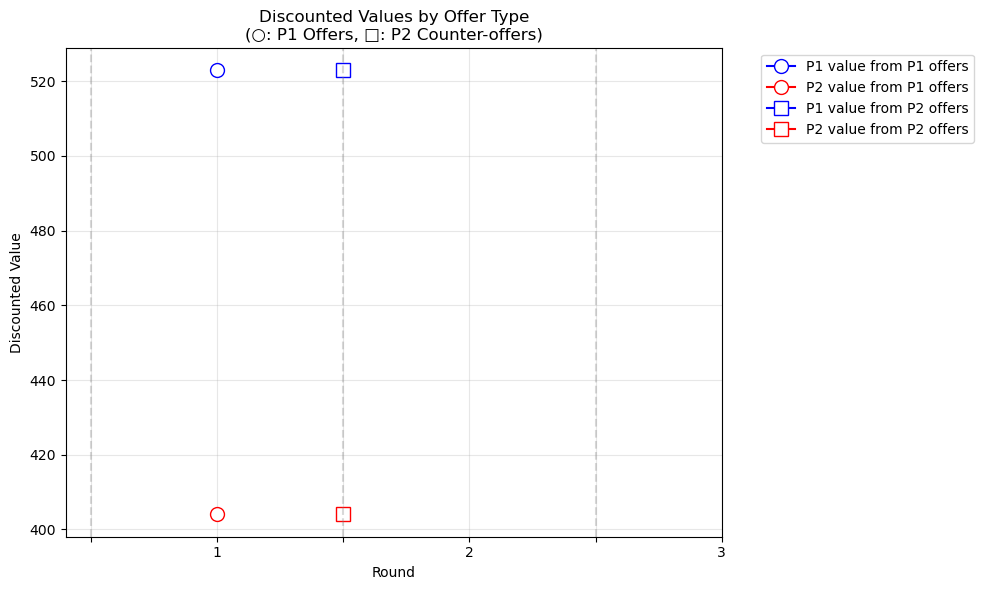

In [24]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 2
Number of P1 offers: 1
Number of P2 offers: 1


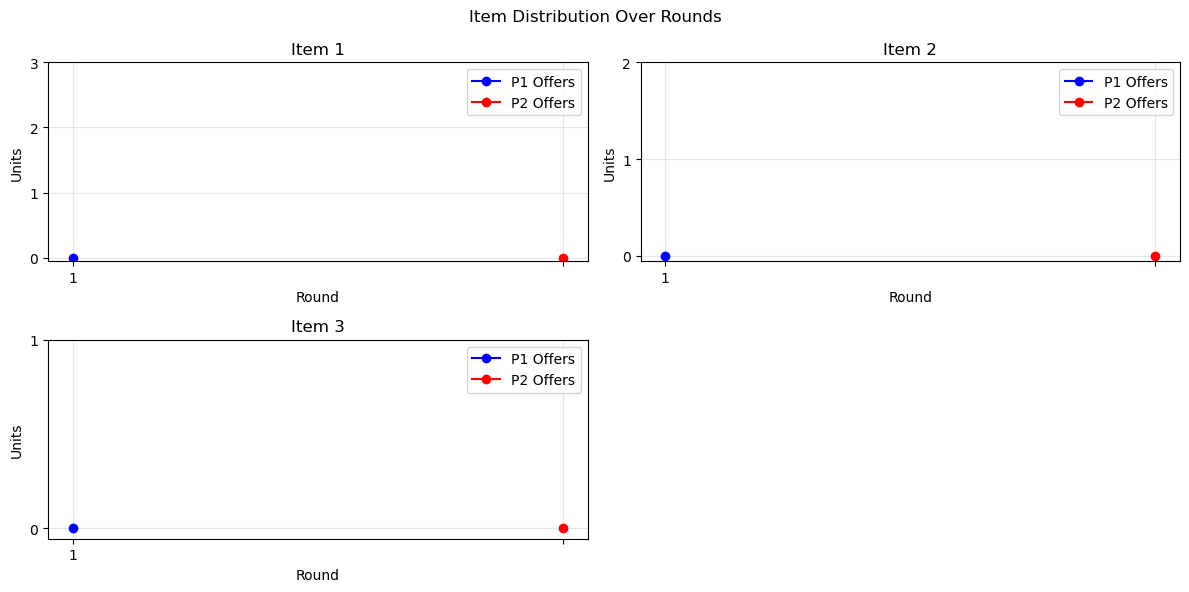

In [25]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [26]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
